In [1]:
import numpy as np
import matplotlib.pyplot as plt
from Corrfunc.theory.DD import DD
import time
import numpy.ma as ma
import sys
import scipy.optimize as sp
import emcee
import matplotlib as mpl

sys.path.append('/home/vibin/MyFolder/WorkDesk/DP2/Codes/Clustering_analysis_PS1_and_shen')
from Clustering_module import *

DP2_DIRECTORY = "/home/vibin/MyFolder/WorkDesk/DP2/"

def p_corr_fun(r, r0, delta, r_min, r_max):
    #A = (1 - delta)/(pow(r0, delta) * (pow(r_max, 1 - delta) - pow(r_min, 1 - delta)))
    return pow(r/r0, -delta) 

xi_r = np.vectorize(p_corr_fun)

def get_r_from_prob(r0, delta, r_min, r_max):
    c = np.random.uniform(0, 1, 1)[0]
    A = (1 - delta)/(pow(r0, delta) * (pow(r_max, 1 - delta) - pow(r_min, 1 - delta)))
    temp1 = (1 - delta)/(A * pow(r0, delta)) * c + pow(r_min, 1 - delta)
    return pow(temp1, 1/(1 - delta))

get_r_from_prob_vec = np.vectorize(get_r_from_prob)

def make_clust_dist(num, r0, delta, box_size, r_min, r_max):
    dat_array = np.random.uniform(0, box_size, (3, 1))
    i = 0

    while i < (num - 1):
        r = get_r_from_prob(r0, delta, r_min, r_max)
        phi = np.random.uniform(0, 2 * np.pi, 1)[0]
        z = np.random.uniform(-r, r, 1)[0]
        theta = np.arccos(z/r)
        if np.isnan(theta):
            print(z/r)

        new_add = np.array([r * np.sin(theta) * np.cos(phi), r * np.sin(theta) * np.sin(phi), z])
        new_pt = np.reshape(dat_array[:,-1] + new_add, (3,1))
        if np.any(((new_pt < [[0], [0], [0]]) | (new_pt > [[box_size], [box_size], [box_size]]))):
            continue
        
        dat_array = np.append(dat_array, new_pt, axis=1)
        i += 1

    return dat_array

def make_clust_dist_v3(num, r0, delta, box_size, r_min, r_max, start_cond = None):
    if start_cond == 'center':
        dat_array = np.array([box_size/2, box_size/2, box_size/2]).reshape((3,1))
    else:
        dat_array = np.random.uniform(0, box_size, (3, 1))
    i = 0

    while i < (num - 1):
        r = get_r_from_prob(r0, delta, r_min, r_max)
        phi = np.random.uniform(0, 2 * np.pi, 1)[0]
        z = np.random.uniform(-r, r, 1)[0]
        theta = np.arccos(z/r)
        if np.isnan(theta):
            print(z/r)

        new_add = np.array([r * np.sin(theta) * np.cos(phi), r * np.sin(theta) * np.sin(phi), z])
        new_pt = np.reshape(dat_array[:,-1] + new_add, (3,1))
        if np.any(((new_pt < [[0], [0], [0]]) | (new_pt > [[box_size], [box_size], [box_size]]))):
            new_pt = np.reshape(dat_array[:,-1], (3,1))
        
        dat_array = np.append(dat_array, new_pt, axis=1)
        i += 1

    return dat_array

def quadrant(vel, box_size):
    if vel >= 0:
        return box_size
    else : 
        return 0

quadrant = np.vectorize(quadrant)

def make_clust_dist_v2(num, r0, delta, box_size, r_min, r_max):
    dat_array = np.random.uniform(0, box_size, (3, 1))
    i = 0

    while i < (num - 1):
        r = get_r_from_prob(r0, delta, r_min, r_max)
        phi = np.random.uniform(0, 2 * np.pi, 1)[0]
        z = np.random.uniform(-r, r, 1)[0]
        theta = np.arccos(z/r)
        if np.isnan(theta):
            print(z/r)

        new_add = np.array([r * np.sin(theta) * np.cos(phi), r * np.sin(theta) * np.sin(phi), z])
        new_pt = np.reshape(dat_array[:,-1] + new_add, (3,1))
        if np.any(((new_pt < [[0], [0], [0]]) | (new_pt > [[box_size], [box_size], [box_size]]))):
#------------------------------------------------------------------------------------------------------
            old_pt = dat_array[:,-1]

            vel = new_pt.flatten() - old_pt
            rem_dist = quadrant(vel, box_size) - old_pt
            print(vel, rem_dist)

            time_taken = np.min(rem_dist/vel)
            new_pt = np.reshape(vel * time_taken, (3,1))
#------------------------------------------------------------------------------------------------------
        
        dat_array = np.append(dat_array, new_pt, axis=1)
        i += 1

    return dat_array

def calc_corr_fun(x_dat, y_dat, z_dat, x_ran, y_ran, z_ran, bins):
    
    bin_avg = np.array((bins[:-1] + bins[1:])/2)

    results = DD(autocorr=1, nthreads=1, binfile=bins, X1=x_ran, Y1=y_ran, Z1=z_ran, periodic=False)
    results = np.array(list(map(list, results)))
    RR_count = results[:,3]/2
    #plt.stairs(RR_count, bins)

    results = DD(autocorr=1, nthreads=1, binfile=bins, X1=x_dat, Y1=y_dat, Z1=z_dat, periodic=False)
    results = np.array(list(map(list, results)))
    DD_count = results[:,3]/2
    #plt.stairs(DD_count, bins)

    results = DD(autocorr=0, nthreads=1, binfile=bins, X1=x_dat, Y1=y_dat, Z1=z_dat, X2=x_ran, Y2=y_ran, Z2=z_ran, periodic=False)
    results = np.array(list(map(list, results)))
    DR_count = results[:,3]
    #plt.stairs(DR_count, bins)

    DD_norm = (len(x_dat) * (len(x_dat) - 1))/2
    RR_norm = (len(x_ran) * (len(x_ran) - 1))/2
    DR_norm = len(x_dat) * len(x_ran)

    xi = ma.masked_values(DD_count * RR_count * DR_count, 0)
    error = ma.masked_values(DD_count * RR_count * DR_count, 0)
    xi[~xi.mask]= (DD_count[~xi.mask]/DD_norm - 2 * DR_count[~xi.mask]/DR_norm + RR_count[~xi.mask]/RR_norm)/ (RR_count[~xi.mask]/RR_norm)
    error[~error.mask] = (1 + xi[~xi.mask])/np.sqrt(np.minimum(DD_count[~xi.mask], len(x_dat)))
    

    fig, ax = plt.subplots(figsize=(7,7))
    ax.errorbar(bin_avg, xi, yerr=error, marker='.', ls='', label=r"$\xi$ of the simulation")
    
    if len(bin_avg[xi.mask]) != 0 :
        ax.plot(bin_avg[xi.mask], np.zeros_like(bin_avg[xi.mask]), 'r.', label="bins with any of the counts zero")
    ax.axhline(0)
    ax.set_xlabel('r')
    ax.set_ylabel(r'$\xi(r)$')

    ax.legend()
    return ax, xi, error

def Look_into(x_dat, y_dat, z_dat, r0_model, delta, n_d, n_r, bins, box_size, r_min, r_max):
    start = time.time()

    x_ran, y_ran, z_ran = np.random.uniform(0, box_size, (3, n_r))

    ax, xi, error = calc_corr_fun(x_dat, y_dat, z_dat, x_ran, y_ran, z_ran, bins)
    #ax.set_title("data with pow law clustering with $r_0$ = {}, $\delta$ = {}, $n_d$ = {}, $n_r$ = {}, box size = {}\n data density = {}".format(r0, delta, n_d, n_r, box_size, (n_d/ pow(box_size,3))))

    bin_avg = np.array((bins[:-1] + bins[1:])/2)
    r_vals = bin_avg
    xi_vals = xi_r(r_vals, r0_model, delta, r_min, r_max)

    ax.plot(r_vals, xi_vals, label="pow law function")

    end = time.time()
    print("Total time take = {} s".format(round(end-start,2)))

    return ax, xi, error

def Look_into_v2(x_dat, y_dat, z_dat, x_ran, y_ran, z_ran, r0_model, delta, n_d, bins, box_size, r_min, r_max):
    start = time.time()

    ax, xi, error = calc_corr_fun(x_dat, y_dat, z_dat, x_ran, y_ran, z_ran, bins)
    #ax.set_title("data with pow law clustering with $r_0$ = {}, $\delta$ = {}, $n_d$ = {}, $n_r$ = {}, box size = {}\n data density = {}".format(r0, delta, n_d, n_r, box_size, (n_d/ pow(box_size,3))))

    bin_avg = np.array((bins[:-1] + bins[1:])/2)
    r_vals = bin_avg
    xi_vals = xi_r(r_vals, r0_model, delta, r_min, r_max)

    ax.plot(r_vals, xi_vals, label="pow law function")

    end = time.time()
    print("Total time take = {} s".format(round(end-start,2)))

    return ax, xi, error


def completness_map_effects_without_ran_adjust(x_dat2, y_dat2, z_dat2, compl_map):
    fig, ax_com = plt.subplots(figsize=(8,6))

    ax_com.stairs(compl_map, grade, fill=True)
    ax_com.set_title("Completeness map")
    ax_com.set_ylabel("Completeness")
    ax_com.set_xlabel("z")

    xi2 = np.zeros((10, len(bins)-1))
    error2 = np.zeros((10, len(bins)-1))
    for i in range(10):

        x_dat_incompl = np.array([])
        y_dat_incompl = np.array([])
        z_dat_incompl = np.array([])

        for j in range(len(compl_map)):
            ind = np.where((z_dat2 >= grade[j]) & (z_dat2 < grade[j+1]))
            num = len(ind[0])
            req_num = int(num * compl_map[j])

            taken = np.random.choice(ind[0], req_num)
            z_dat_incompl = np.append(z_dat_incompl, (z_dat2[taken]))
            x_dat_incompl = np.append(x_dat_incompl, (x_dat2[taken]))
            y_dat_incompl = np.append(y_dat_incompl, (y_dat2[taken]))

        ax, xi_, error_ = Look_into(x_dat_incompl, y_dat_incompl, z_dat_incompl, r0_model = r0_model, delta = delta, n_d = n_d, n_r = n_r, bins=bins, box_size=box_size, r_min=r_min, r_max=r_max);
        xi2[i] = xi_
        error2[i] = error_
        plt.close()

    print("The number of data points retained =", len(z_dat_incompl))

    return xi2, error2

def completness_map_effects_without_ran_adjust_v2(x_dat2, y_dat2, z_dat2, compl_map, grade, bins, box_size):
    fig, ax_com = plt.subplots(figsize=(8,6))

    ax_com.stairs(compl_map, grade, fill=True)
    ax_com.set_title("Completeness map")
    ax_com.set_ylabel("Completeness")
    ax_com.set_xlabel("z")

    xi2 = np.zeros((10, len(bins)-1))
    error2 = np.zeros((10, len(bins)-1))

    n_r = 1 * len(x_dat2)

    for i in range(10):

        x_dat_incompl = np.array([])
        y_dat_incompl = np.array([])
        z_dat_incompl = np.array([])

        for j in range(len(compl_map)):
            ind = np.where((z_dat2 >= grade[j]) & (z_dat2 < grade[j+1]))
            num = len(ind[0])
            req_num = int(num * compl_map[j])

            taken = np.random.choice(ind[0], req_num)
            z_dat_incompl = np.append(z_dat_incompl, (z_dat2[taken]))
            x_dat_incompl = np.append(x_dat_incompl, (x_dat2[taken]))
            y_dat_incompl = np.append(y_dat_incompl, (y_dat2[taken]))


        x_ran, y_ran, z_ran = np.random.uniform(0, box_size, (3, n_r))

        ax, xi_, error_ = calc_corr_fun(x_dat_incompl, y_dat_incompl, z_dat_incompl, x_ran, y_ran, z_ran, bins)
        xi2[i] = xi_
        error2[i] = error_
        plt.close()

    print("The number of data points retained =", len(z_dat_incompl))

    return xi2, error2

def completness_map_effects_with_ran_adjust(x_dat2, y_dat2, z_dat2, compl_map):
    fig, ax_com = plt.subplots(figsize=(8,6))

    ax_com.stairs(compl_map, grade, fill=True)
    ax_com.set_title("Completeness map")
    ax_com.set_ylabel("Completeness")
    ax_com.set_xlabel("z")

    xi3 = np.zeros((10, len(bins)-1))
    error3 = np.zeros((10, len(bins)-1))
    for i in range(10):

        x_ran, y_ran, z_ran = np.random.uniform(0, box_size, (3, n_r))
        x_ran_incompl = np.array([])
        y_ran_incompl = np.array([])
        z_ran_incompl = np.array([])

        x_dat_incompl = np.array([])
        y_dat_incompl = np.array([])
        z_dat_incompl = np.array([])

        for j in range(len(compl_map)):
            ind = np.where((z_dat2 >= grade[j]) & (z_dat2 < grade[j+1]))
            ind_ran = np.where((z_ran >= grade[j]) & (z_ran < grade[j+1]))
            num = len(ind[0])
            num_ran = len(ind_ran[0])
            req_num = int(num * compl_map[j])
            req_num_ran = int(num_ran * compl_map[j])

            taken = np.random.choice(ind[0], req_num)
            z_dat_incompl = np.append(z_dat_incompl, (z_dat2[taken]))
            x_dat_incompl = np.append(x_dat_incompl, (x_dat2[taken]))
            y_dat_incompl = np.append(y_dat_incompl, (y_dat2[taken]))

            taken_ran = np.random.choice(ind_ran[0], req_num_ran)
            z_ran_incompl = np.append(z_ran_incompl, (z_ran[taken_ran]))
            x_ran_incompl = np.append(x_ran_incompl, (x_ran[taken_ran]))
            y_ran_incompl = np.append(y_ran_incompl, (y_ran[taken_ran]))


        ax, xi_, error_ = Look_into_v2(x_dat_incompl, y_dat_incompl, z_dat_incompl, x_ran_incompl, y_ran_incompl, z_ran_incompl, r0_model = r0_model, delta = delta, n_d = n_d, bins=bins, box_size=box_size, r_min=r_min, r_max=r_max);
        xi3[i] = xi_
        error3[i] = error_
        plt.close()

    print("The number of data points retained =", len(z_dat_incompl))

    return xi3, error3

def completness_map_effects_with_ran_adjust_v2(x_dat2, y_dat2, z_dat2, compl_map, grade, bins, box_size):
    fig, ax_com = plt.subplots(figsize=(8,6))

    ax_com.stairs(compl_map, grade, fill=True)
    ax_com.set_title("Completeness map")
    ax_com.set_ylabel("Completeness")
    ax_com.set_xlabel("z")

    xi3 = np.zeros((10, len(bins)-1))
    error3 = np.zeros((10, len(bins)-1))

    n_r = 1 * len(x_dat2)
    
    for i in range(10):

        x_ran, y_ran, z_ran = np.random.uniform(0, box_size, (3, n_r))
        x_ran_incompl = np.array([])
        y_ran_incompl = np.array([])
        z_ran_incompl = np.array([])

        x_dat_incompl = np.array([])
        y_dat_incompl = np.array([])
        z_dat_incompl = np.array([])

        for j in range(len(compl_map)):
            ind = np.where((z_dat2 >= grade[j]) & (z_dat2 < grade[j+1]))
            ind_ran = np.where((z_ran >= grade[j]) & (z_ran < grade[j+1]))
            num = len(ind[0])
            num_ran = len(ind_ran[0])
            req_num = int(num * compl_map[j])
            req_num_ran = int(num_ran * compl_map[j])

            taken = np.random.choice(ind[0], req_num)
            z_dat_incompl = np.append(z_dat_incompl, (z_dat2[taken]))
            x_dat_incompl = np.append(x_dat_incompl, (x_dat2[taken]))
            y_dat_incompl = np.append(y_dat_incompl, (y_dat2[taken]))

            taken_ran = np.random.choice(ind_ran[0], req_num_ran)
            z_ran_incompl = np.append(z_ran_incompl, (z_ran[taken_ran]))
            x_ran_incompl = np.append(x_ran_incompl, (x_ran[taken_ran]))
            y_ran_incompl = np.append(y_ran_incompl, (y_ran[taken_ran]))


        ax, xi_, error_ = calc_corr_fun(x_dat_incompl, y_dat_incompl, z_dat_incompl, x_ran_incompl, y_ran_incompl, z_ran_incompl, bins)
        xi3[i] = xi_
        error3[i] = error_
        plt.close()

    print("The number of data points retained =", len(z_dat_incompl))

    return xi3, error3

def compare_compl_effect_with_original(xi2, error2, xi, error, title=None):
    fig, (ax, ax_bot) = plt.subplots(2,1,figsize=(12,8), height_ratios=(5,3), sharex=True)

    xi_avg = np.average(xi, axis=0)
    error_avg = np.sqrt(np.average(error**2, axis=0)/len(error))

    ax.errorbar(bin_avg, xi_avg, yerr=error_avg, marker='.', ls='', label="Complete data")

    xi_avg2 = np.average(xi2, axis=0)
    error_avg2 = np.sqrt(np.average(error2**2, axis=0)/len(error))

    ax.errorbar(bin_avg, xi_avg2, yerr=error_avg2, marker='.', ls='', label="incomplete data")
    ax.set_title(title)
    ax.set_xlabel("r")
    ax.set_ylabel(r"$\xi$")
    ax.legend()

    diff_xi = (xi_avg2 - xi_avg)/((error_avg + error_avg2)/2)

    ax_bot.plot(bin_avg, diff_xi, marker='.', ls='')
    ax_bot.axhline(0, ls='--')
    ax_bot.axhline(2, ls='--')
    ax_bot.axhline(-2, ls='--')
    ax_bot.set_xlabel("r")
    ax_bot.set_ylabel("diff/err")

    return diff_xi



In [ ]:
file_name = "mock_data_v1.npy"
data = np.load(file_name)

x_dat2, y_dat2, z_dat2 = data

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(x_dat2, y_dat2, z_dat2, s=4)
#ax.plot(x_dat2, y_dat2, z_dat2, c='r', lw=0.5)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title("Distribution of clustered points following power law")


n_d = len(x_dat2)
r0_model = 1.0
delta = 2.0
box_size = 10

r_min, r_max = 0.5, 10

n_r = 10 * n_d
bin_start = 0.5
bin_end = 10
bin_width = 0.05

bins = np.arange(bin_start, bin_end, bin_width)
bin_avg = np.array((bins[:-1] + bins[1:])/2)


xi = np.zeros((10, len(bins)-1))
error = np.zeros((10, len(bins)-1))
for i in range(10):
    grade = np.arange(0, 10.1, 0.1)
    compl_map = np.ones_like(grade[:-1])

    x_dat_incompl = np.array([])
    y_dat_incompl = np.array([])
    z_dat_incompl = np.array([])

    for j in range(len(compl_map)):
        ind = np.where((z_dat2 >= grade[j]) & (z_dat2 < grade[j+1]))
        num = len(ind[0])
        req_num = int(num * compl_map[j])

        taken = np.random.choice(ind[0], req_num)
        z_dat_incompl = np.append(z_dat_incompl, (z_dat2[taken]))
        x_dat_incompl = np.append(x_dat_incompl, (x_dat2[taken]))
        y_dat_incompl = np.append(y_dat_incompl, (y_dat2[taken]))

    ax, xi_, error_ = Look_into(x_dat_incompl, y_dat_incompl, z_dat_incompl, r0_model = r0_model, delta = delta, n_d = n_d, n_r = n_r, bins=bins, box_size=box_size, r_min=r_min, r_max=r_max);
    xi[i] = xi_
    error[i] = error_
    plt.close()

fig, ax = plt.subplots(figsize=(12,6))

xi_avg = np.average(xi, axis=0)
error_avg = np.sqrt(np.average(error**2, axis=0)/len(error))

ax.errorbar(bin_avg, xi_avg, yerr=error_avg, marker='.', ls='')
ax.set_title("xi avg of fully complete data")
ax.set_xlabel("r")
ax.set_ylabel(r"$\xi$")



Total time take = 2.6 s
Total time take = 2.52 s
Total time take = 2.54 s
Total time take = 2.59 s
Total time take = 2.56 s
Total time take = 2.6 s
Total time take = 2.5 s
Total time take = 2.51 s
Total time take = 2.57 s
Total time take = 2.57 s
The number of data points retained = 1000


array([-1.10012914, -0.91297681, -0.2597909 , -3.28765778, -3.99023779,
        0.81413232,  3.28966302, -1.48665548, -1.38574374,  1.21604467,
       -3.36157297,  0.63138345,  1.26038035, -1.42945059, -3.70595656,
        4.15340165, -0.28816073, -3.85879855, -4.84988816,  1.29951128,
       -0.61910553, -1.55076119,  3.38738564,  0.63568219, -2.46511257,
       -0.70264926, -1.36080919, -3.36124586, -2.0255501 ,  0.28746461,
       -6.8003369 , -0.81745104, -2.75719147, -1.99608029, -2.24308845,
        2.59615063,  1.95744206, -0.84442008, -6.96949633, -0.23915535,
        1.31848099, -1.55131189, -1.69877489,  0.49853658,  1.35832722,
        0.47488675,  0.21718527,  0.252594  ,  0.1506183 , -4.97701473,
        0.10806132, -2.44006322, -3.26411544,  1.2060017 , -3.06616257,
        0.87942607, -0.14165352,  0.87968478,  2.83583862, -2.81923315,
        3.91473016,  0.12207234, -0.39249599, -1.75941485,  0.82410539,
       -2.23458329, -0.07903698,  0.14574493,  1.14852993,  1.31

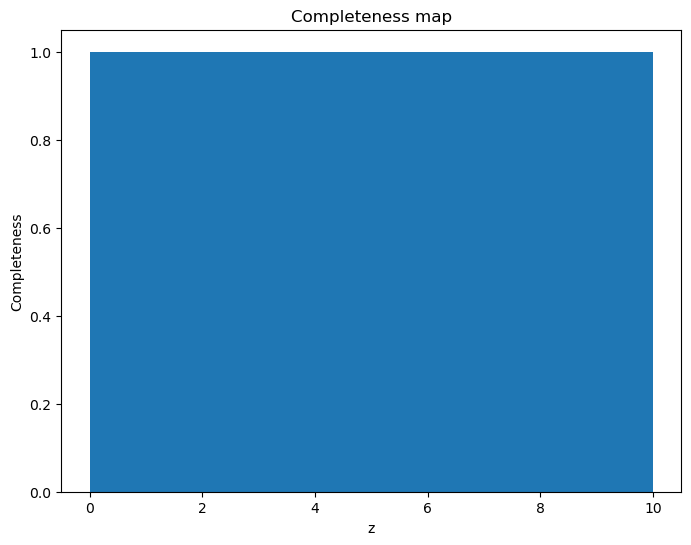

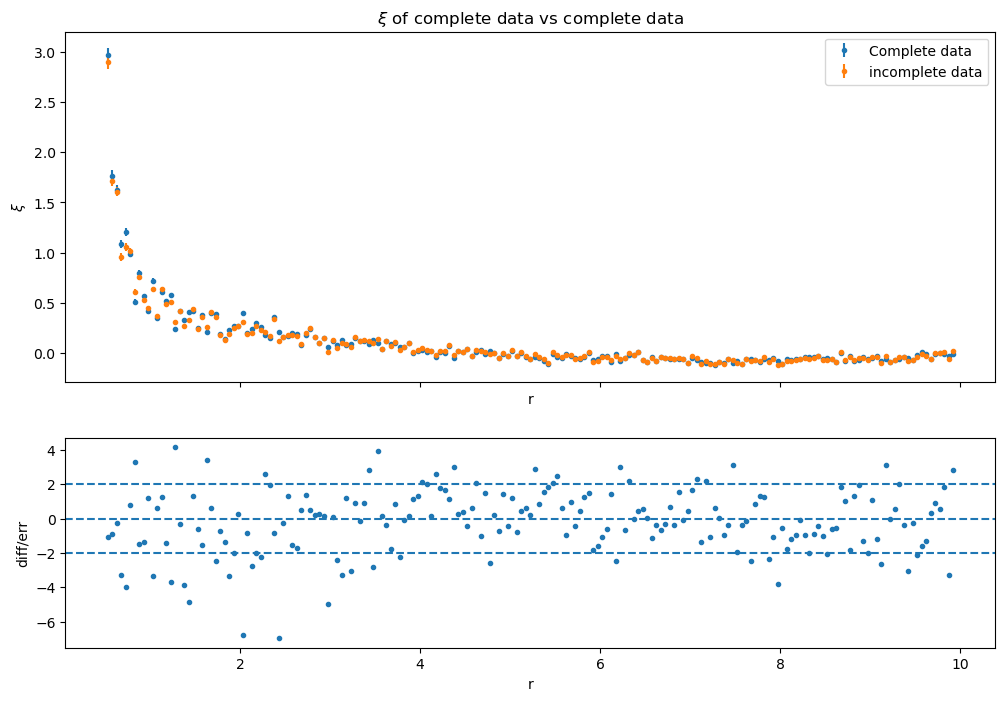

In [3]:
grade = np.arange(0, 10.1, 0.1)
compl_map = np.ones_like(grade[:-1])

xi2, error2 = completness_map_effects_without_ran_adjust(x_dat2, y_dat2, z_dat2, compl_map)

compare_compl_effect_with_original(xi2, error2, xi, error, title=r"$\xi$ of complete data vs complete data")

Total time take = 2.77 s
Total time take = 2.66 s
Total time take = 2.7 s
Total time take = 2.71 s
Total time take = 2.77 s
Total time take = 2.76 s
Total time take = 2.73 s
Total time take = 2.61 s
Total time take = 2.89 s
Total time take = 3.02 s
The number of data points retained = 747


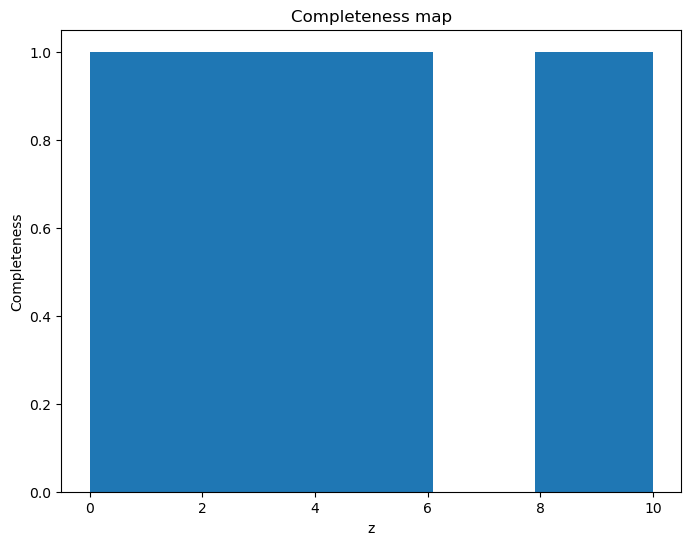

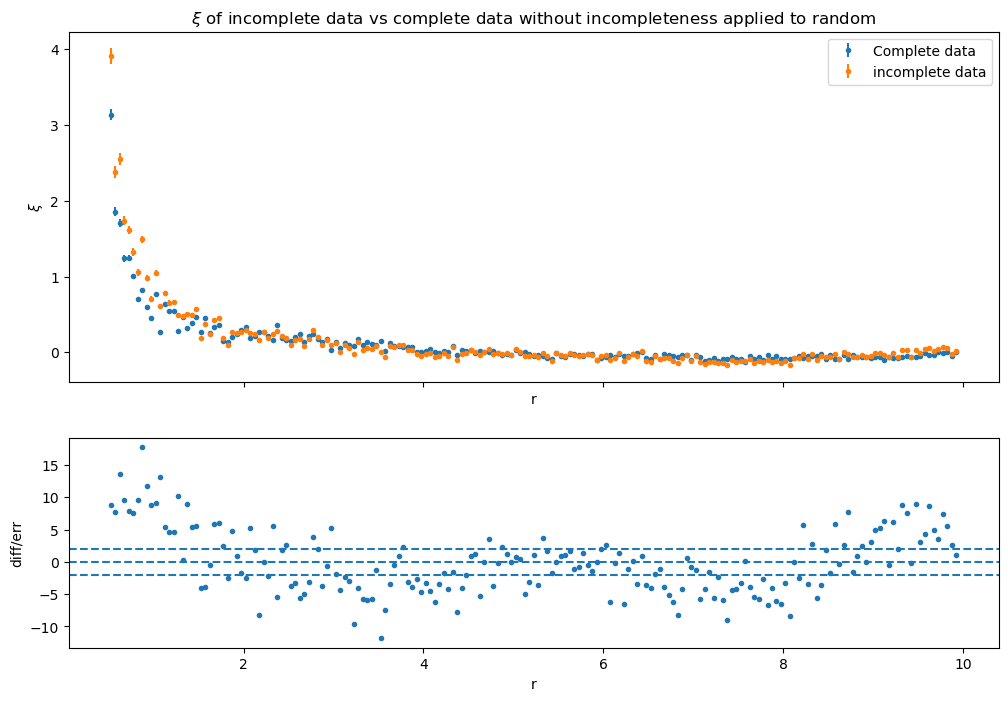

In [24]:
grade = np.arange(0, 10.1, 0.1)
compl_map = np.ones_like(grade[:-1])
grade_avg = np.array((grade[:-1] + grade[1:])/2)
ind = np.where((grade > 6) & (grade < 8))[0]
compl_map[ind[np.where((ind[1:] - ind[:-1]) == 1)]] = 0

xi2, error2 = completness_map_effects_without_ran_adjust(x_dat2, y_dat2, z_dat2, compl_map)

compare_compl_effect_with_original(xi2, error2, xi, error, title=r"$\xi$ of incomplete data vs complete data without incompleteness applied to random")

Total time take = 1.5 s
Total time take = 1.55 s
Total time take = 1.47 s
Total time take = 1.49 s
Total time take = 1.55 s
Total time take = 1.53 s
Total time take = 1.53 s
Total time take = 1.56 s
Total time take = 1.57 s
Total time take = 1.66 s
The number of data points retained = 747


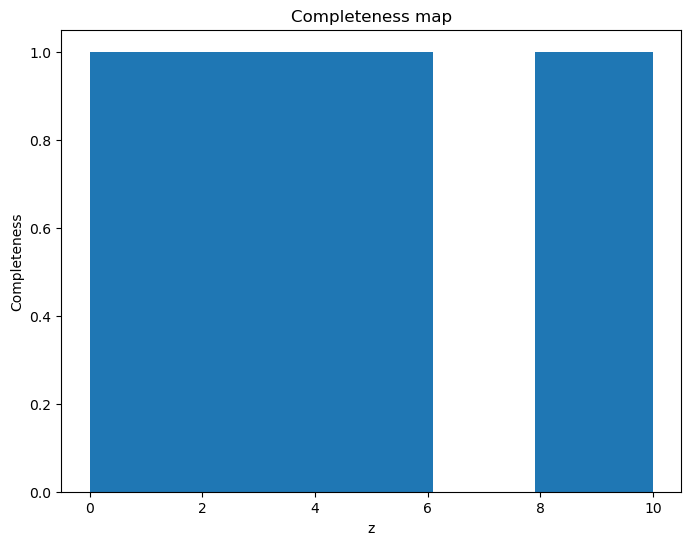

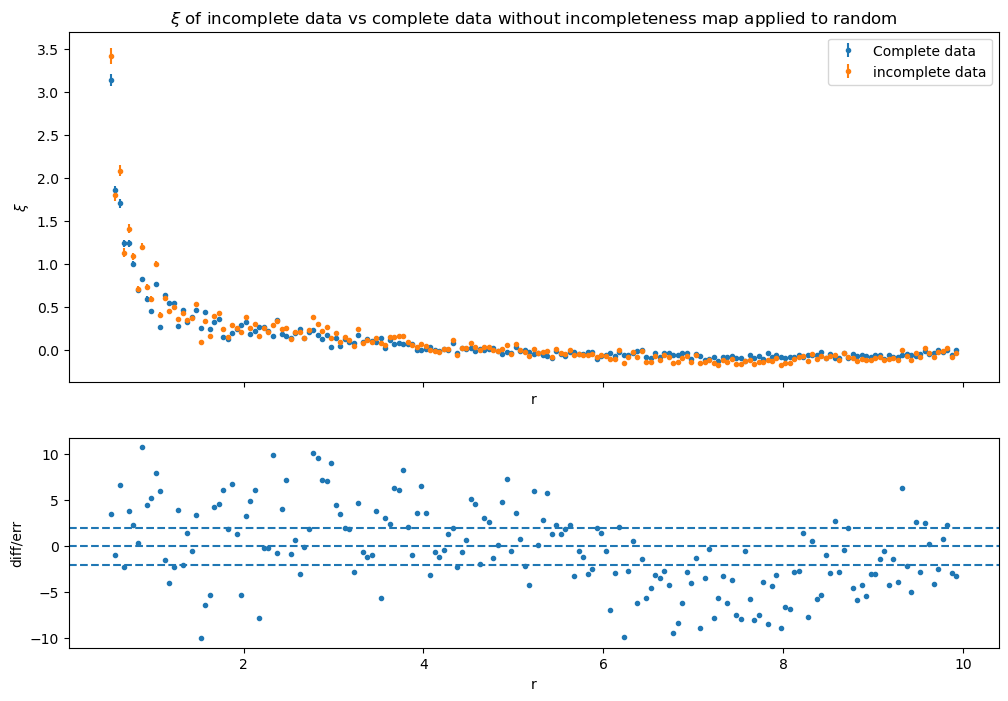

In [20]:
grade = np.arange(0, 10.1, 0.1)
compl_map = np.ones_like(grade[:-1])
grade_avg = np.array((grade[:-1] + grade[1:])/2)
ind = np.where((grade > 6) & (grade < 8))[0]
compl_map[ind[np.where((ind[1:] - ind[:-1]) == 1)]] = 0

xi2, error2 = completness_map_effects_with_ran_adjust(x_dat2, y_dat2, z_dat2, compl_map)

compare_compl_effect_with_original(xi2, error2, xi, error, title=r"$\xi$ of incomplete data vs complete data with incompleteness applied to random")

In [ ]:


xi_avg = np.average(xi, axis=0)
error_avg = np.sqrt(np.average(error**2, axis=0)/len(error))

xi_avg_arr = np.zeros((100, len(bin_avg)))
error_avg_arr = np.zeros((100, len(bin_avg)))

for i in range(100):

    xi2, error2 = completness_map_effects_without_ran_adjust(x_dat2, y_dat2, z_dat2, compl_map)

    xi_avg_arr[i] = np.average(xi2, axis=0)
    error_avg_arr[i] = np.sqrt(np.average(error2**2, axis=0)/len(error))


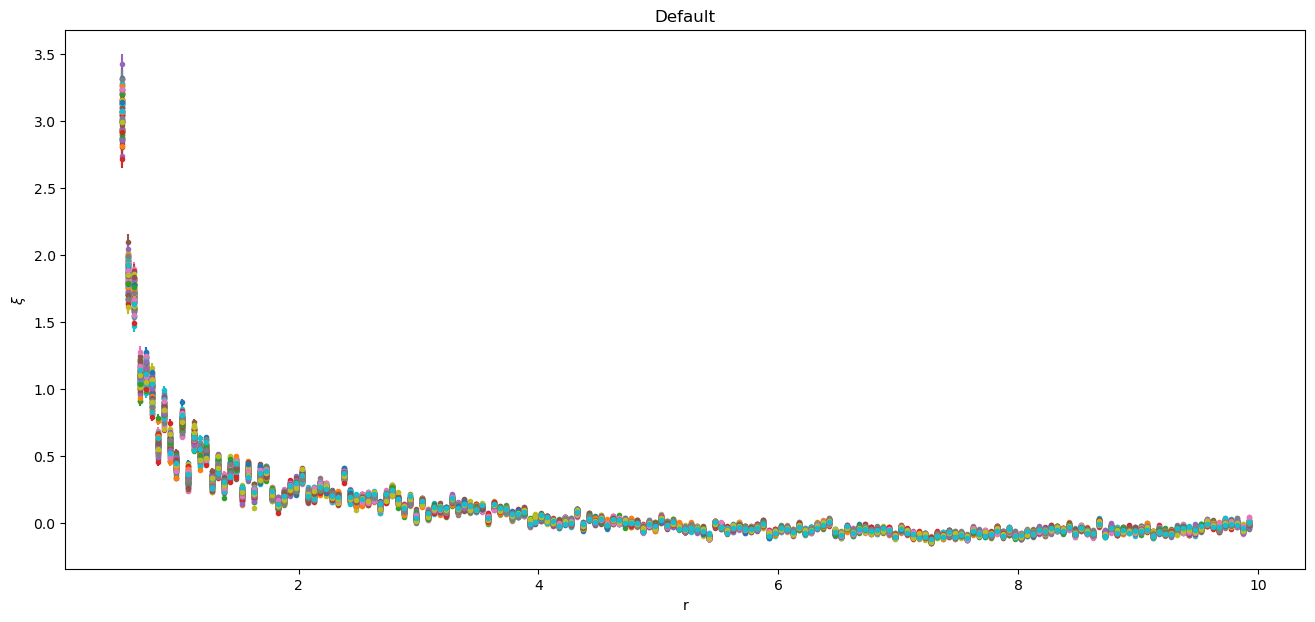

In [10]:
fig, ax = plt.subplots(figsize=(16,7))

for i in range(100):
    ax.errorbar(bin_avg, xi_avg_arr[i], yerr=error_avg_arr[i], marker='.', ls='')
    ax.set_title("Default")
    ax.set_xlabel("r")
    ax.set_ylabel(r"$\xi$")

Text(0, 0.5, 'diff/err')

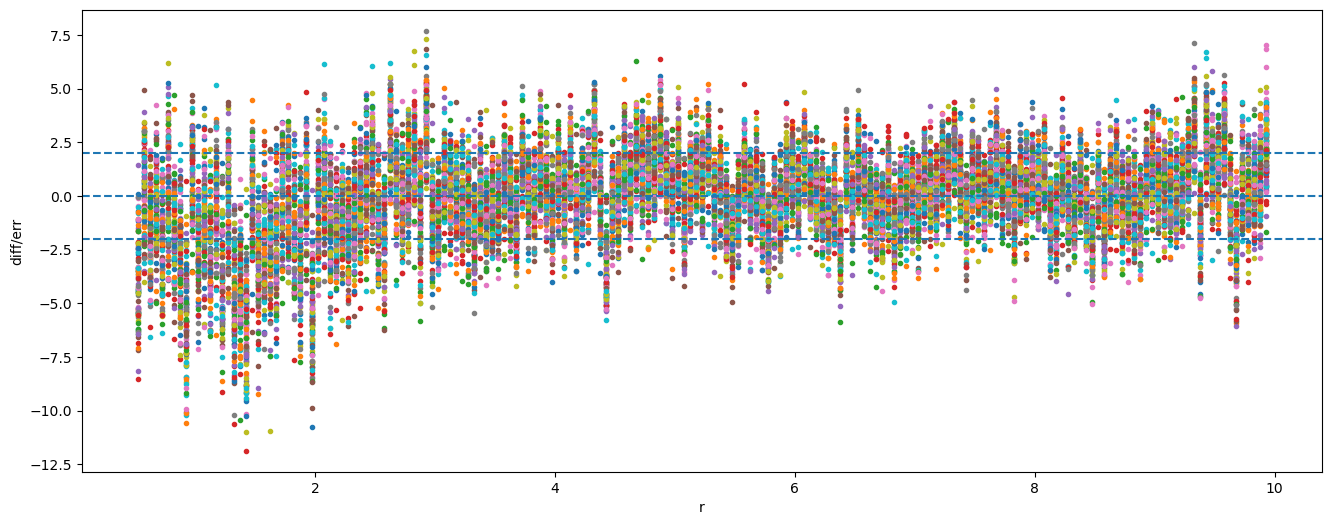

In [11]:
fig, ax_bot = plt.subplots(figsize = (16,6))

for i in range(100):
    diff_xi = (xi_avg_arr[i] - xi_avg)/((error_avg + error_avg_arr[i])/2)

    ax_bot.plot(bin_avg, diff_xi, marker='.', ls='')
ax_bot.axhline(0, ls='--')
ax_bot.axhline(2, ls='--')
ax_bot.axhline(-2, ls='--')
ax_bot.set_xlabel("r")
ax_bot.set_ylabel("diff/err")

In [12]:
grade = np.arange(0, 10.1, 0.1)
compl_map = np.ones_like(grade[:-1])
grade_avg = np.array((grade[:-1] + grade[1:])/2)
ind = np.where((grade > 6) & (grade < 8))[0]
compl_map[ind[np.where((ind[1:] - ind[:-1]) == 1)]] = 0

xi_avg = np.average(xi, axis=0)
error_avg = np.sqrt(np.average(error**2, axis=0)/len(error))

xi_avg_arr = np.zeros((100, len(bin_avg)))
error_avg_arr = np.zeros((100, len(bin_avg)))

for i in range(100):

    xi2, error2 = completness_map_effects_with_ran_adjust(x_dat2, y_dat2, z_dat2, compl_map)

    xi_avg_arr[i] = np.average(xi2, axis=0)
    error_avg_arr[i] = np.sqrt(np.average(error2**2, axis=0)/len(error))
    plt.close()

Total time take = 1.43 s
Total time take = 1.46 s
Total time take = 1.46 s
Total time take = 1.49 s
Total time take = 1.51 s
Total time take = 1.54 s
Total time take = 1.54 s
Total time take = 1.5 s
Total time take = 1.54 s
Total time take = 1.56 s
The number of data points retained = 747
Total time take = 1.59 s
Total time take = 1.58 s
Total time take = 1.56 s
Total time take = 1.59 s
Total time take = 1.64 s
Total time take = 1.64 s
Total time take = 1.63 s
Total time take = 1.57 s
Total time take = 1.67 s
Total time take = 1.59 s
The number of data points retained = 747
Total time take = 1.65 s
Total time take = 1.63 s
Total time take = 1.62 s
Total time take = 1.61 s
Total time take = 1.67 s
Total time take = 1.68 s
Total time take = 1.64 s
Total time take = 1.63 s
Total time take = 1.69 s
Total time take = 1.71 s
The number of data points retained = 747
Total time take = 1.75 s
Total time take = 1.69 s
Total time take = 1.7 s
Total time take = 1.71 s
Total time take = 1.72 s
Tota

Text(0, 0.5, 'diff/err')

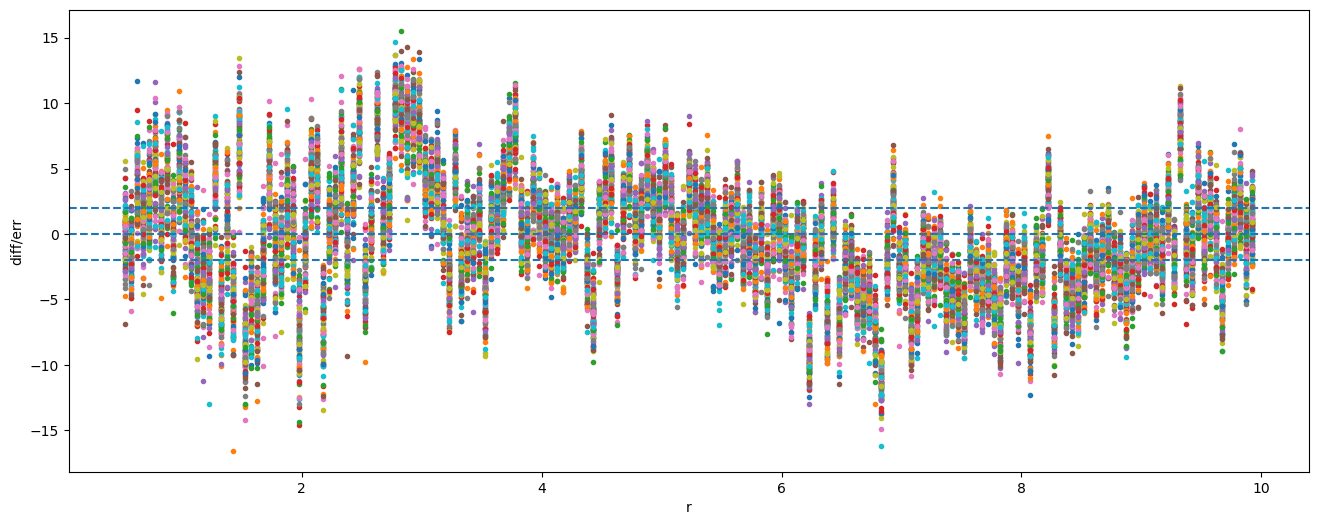

In [13]:
fig, ax_bot = plt.subplots(figsize = (16,6))

for i in range(100):
    diff_xi = (xi_avg_arr[i] - xi_avg)/((error_avg + error_avg_arr[i])/2)

    ax_bot.plot(bin_avg, diff_xi, marker='.', ls='')
ax_bot.axhline(0, ls='--')
ax_bot.axhline(2, ls='--')
ax_bot.axhline(-2, ls='--')
ax_bot.set_xlabel("r")
ax_bot.set_ylabel("diff/err")

## Trying different completeness maps

Total time take = 1.79 s
Total time take = 1.85 s
Total time take = 1.95 s
Total time take = 1.92 s
Total time take = 1.93 s
Total time take = 1.97 s
Total time take = 1.89 s
Total time take = 1.94 s
Total time take = 2.07 s
Total time take = 1.92 s
The number of data points retained = 739


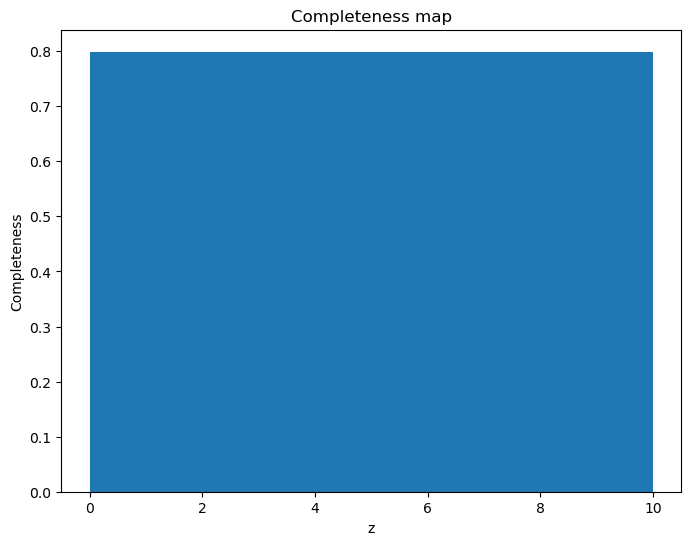

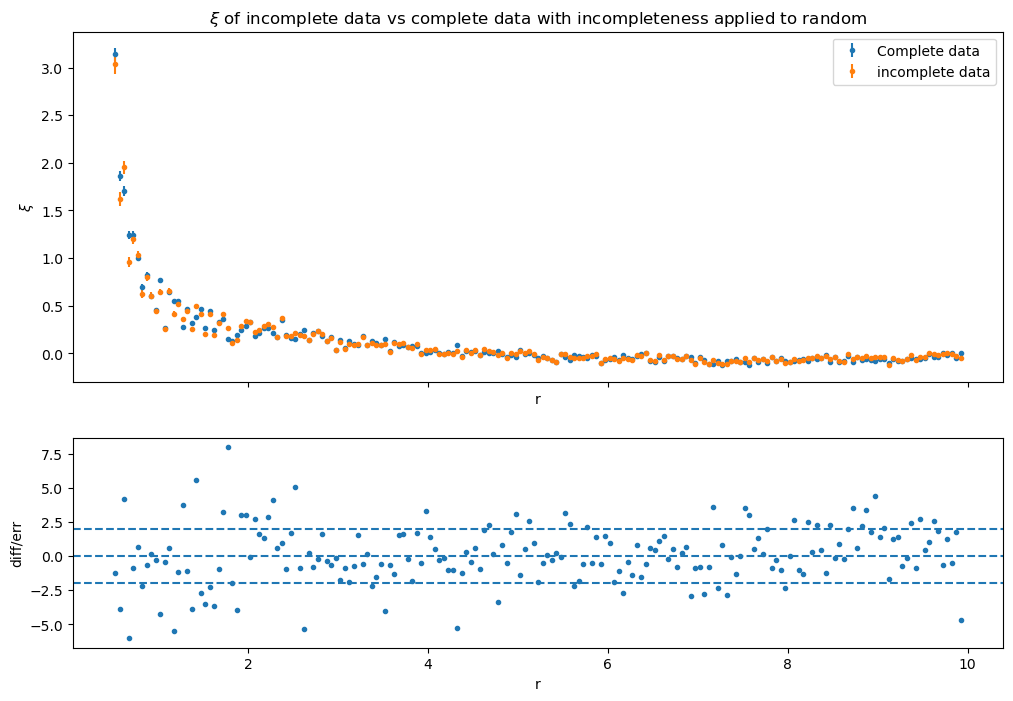

In [26]:
grade = np.arange(0, 10.1, 0.1)
compl_map = np.ones_like(grade[:-1])
grade_avg = np.array((grade[:-1] + grade[1:])/2)
ind = np.where((grade >= 0) & (grade <= 10))[0]
compl_map[ind[np.where((ind[1:] - ind[:-1]) == 1)]] = 0.799

xi2, error2 = completness_map_effects_with_ran_adjust(x_dat2, y_dat2, z_dat2, compl_map)

compare_compl_effect_with_original(xi2, error2, xi, error, title=r"$\xi$ of incomplete data vs complete data with incompleteness applied to random")

## Trying to fit the difference between $\xi$ of complete and incomplete data without random adjust

In [14]:
grade = np.arange(0, 10.1, 0.1)
compl_map = np.ones_like(grade[:-1])
grade_avg = np.array((grade[:-1] + grade[1:])/2)
ind = np.where((grade > 6) & (grade < 8))[0]
compl_map[ind[np.where((ind[1:] - ind[:-1]) == 1)]] = 0

xi2, error2 = completness_map_effects_without_ran_adjust(x_dat2, y_dat2, z_dat2, compl_map);
plt.close()

diff_xi = compare_compl_effect_with_original(xi2, error2, xi, error, title=r"$\xi$ of incomplete data vs complete data without incompleteness applied to random")
plt.close()

Total time take = 2.38 s
Total time take = 2.44 s
Total time take = 2.52 s
Total time take = 2.42 s
Total time take = 2.39 s
Total time take = 2.42 s
Total time take = 2.36 s
Total time take = 2.39 s
Total time take = 2.42 s
Total time take = 2.44 s
The number of data points retained = 747


Text(0, 0.5, 'diff/err')

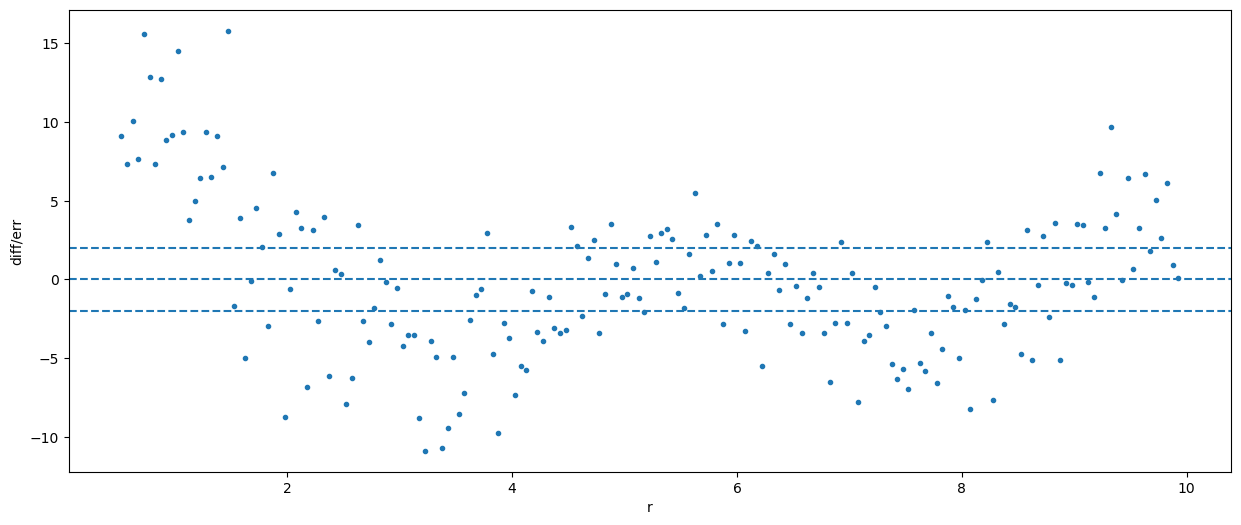

In [4]:
fig, ax_bot = plt.subplots(figsize = (15, 6))

ax_bot.plot(bin_avg, diff_xi, marker='.', ls='')
ax_bot.axhline(0, ls='--')
ax_bot.axhline(2, ls='--')
ax_bot.axhline(-2, ls='--')
ax_bot.set_xlabel("r")
ax_bot.set_ylabel("diff/err")

In [13]:
def fourier_fit_diff_xi(bin_avg, diff_xi, initial_guess):

    def fourier_series(x, w, a0, a1, a2, a3, a4, b1, b2, b3, b4):
        """Dynamically generated fitting function for Fourier series."""
        result = a0 + a1 * np.cos(w * x) + a2 * np.cos(2 * w * x) + a3 * np.cos(3 * w * x) \
                    + a4 * np.cos(4 * w * x) + b1 * np.sin(w * x) + b2 * np.sin(2 * w * x) \
                    + b3 * np.sin(3 * w * x) + b4 * np.sin(4 * w * x)
        
        return result

    fourier_series_v = np.vectorize(fourier_series)

    # Perform curve fitting
    params, _ = sp.curve_fit(fourier_series, bin_avg, diff_xi, p0=initial_guess)
    print(params)

    fig, ax = plt.subplots(figsize=(15,6))

    ax.plot(bin_avg, diff_xi, marker='.', ls='', label='Data points')

    y_fitted = fourier_series_v(bin_avg, *params)
    ax.plot(bin_avg, y_fitted, label='fitted with fourier 4')

    ax.set_ylabel("diff/err")
    ax.set_xlabel('r')
    ax.legend()

    ax.axhline(0, ls='--')
    ax.axhline(2, ls='--')
    ax.axhline(-2, ls='--')


    return params

[ 0.58106324  1.25081651  5.41070116  3.92027474 -0.64553205  0.57206731
  0.81315412  1.04916823  0.33593483  0.74942178]


array([ 0.58106324,  1.25081651,  5.41070116,  3.92027474, -0.64553205,
        0.57206731,  0.81315412,  1.04916823,  0.33593483,  0.74942178])

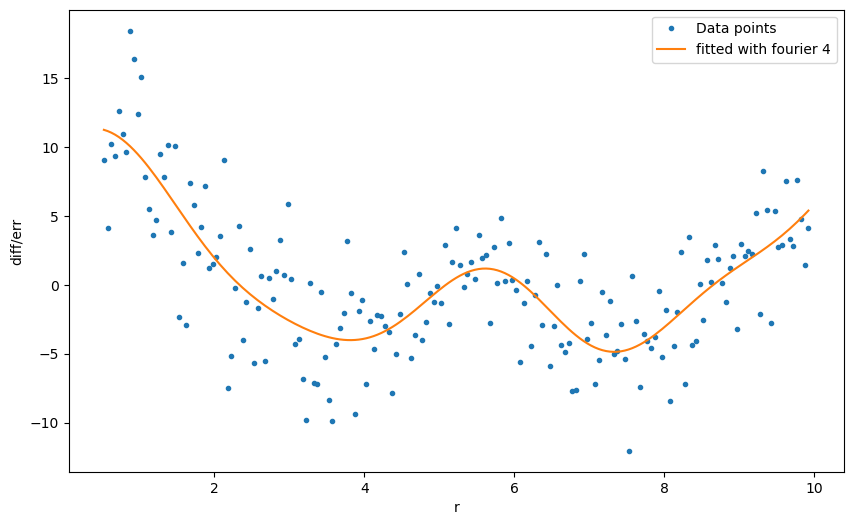

In [19]:
initial_guess = [0.5, 2, 4, 2, 2, 3, 5, 2, 2, 3]
fourier_fit_diff_xi(bin_avg, diff_xi, initial_guess)


In [16]:
grade = np.arange(0, 10.1, 0.1)
compl_map = np.ones_like(grade[:-1])
grade_avg = np.array((grade[:-1] + grade[1:])/2)
ind = np.where((grade > 6) & (grade < 8))[0]
compl_map[ind[np.where((ind[1:] - ind[:-1]) == 1)]] = 0.5

xi2, error2 = completness_map_effects_without_ran_adjust(x_dat2, y_dat2, z_dat2, compl_map);
plt.close()

diff_xi = compare_compl_effect_with_original(xi2, error2, xi, error, title=r"$\xi$ of incomplete data vs complete data without incompleteness applied to random")
plt.close()

Total time take = 2.4 s
Total time take = 2.47 s
Total time take = 2.62 s
Total time take = 2.51 s
Total time take = 2.69 s
Total time take = 2.55 s
Total time take = 2.72 s
Total time take = 2.76 s
Total time take = 2.75 s
Total time take = 2.62 s
The number of data points retained = 870


Text(0, 0.5, 'diff/err')

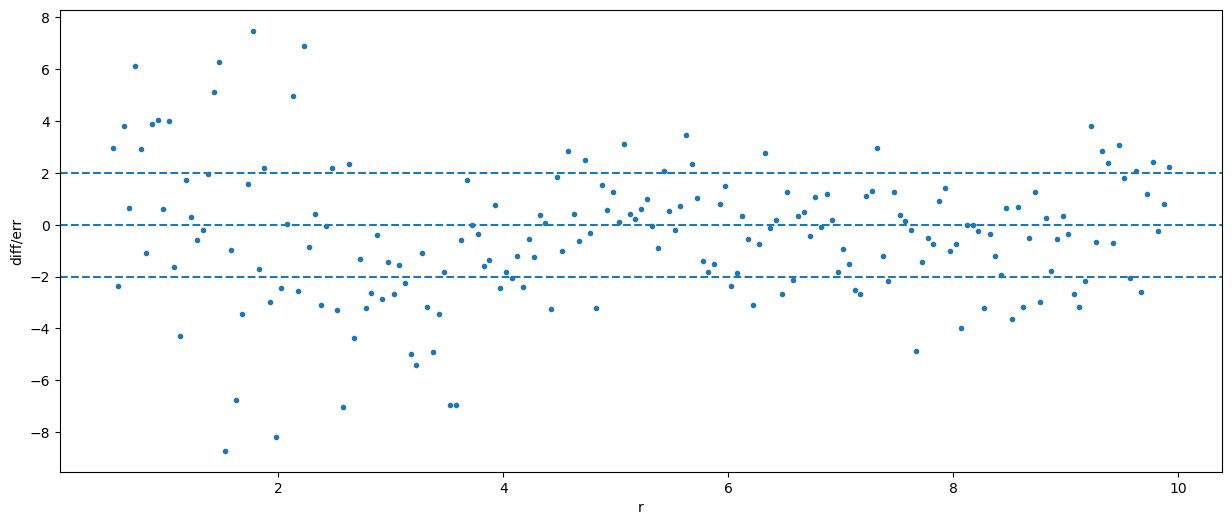

In [17]:
fig, ax_bot = plt.subplots(figsize = (15, 6))

ax_bot.plot(bin_avg, diff_xi, marker='.', ls='')
ax_bot.axhline(0, ls='--')
ax_bot.axhline(2, ls='--')
ax_bot.axhline(-2, ls='--')
ax_bot.set_xlabel("r")
ax_bot.set_ylabel("diff/err")

[ 0.63183913 -0.31458569  0.61369976  1.08273975 -0.18798889  0.51093694
 -0.30181109  0.92510069  0.28668647 -0.06852868]


array([ 0.63183913, -0.31458569,  0.61369976,  1.08273975, -0.18798889,
        0.51093694, -0.30181109,  0.92510069,  0.28668647, -0.06852868])

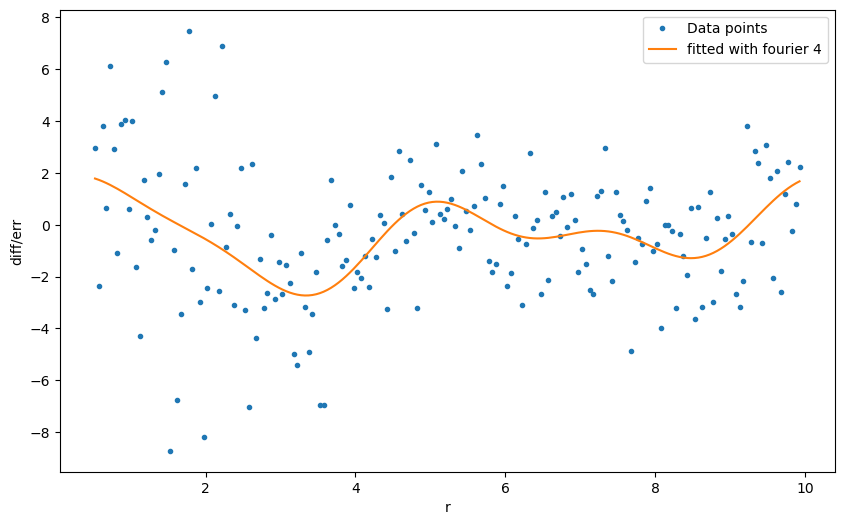

In [18]:
initial_guess = [0.5, 2, 4, 2, 2, 3, 5, 2, 2, 3]
fourier_fit_diff_xi(bin_avg, diff_xi, initial_guess)

## Trying to use mcmc for the fitting of $\Delta \xi/\sigma$ 

In [5]:
grade = np.arange(0, 10.1, 0.1)
compl_map = np.ones_like(grade[:-1])
grade_avg = np.array((grade[:-1] + grade[1:])/2)
ind = np.where((grade > 6) & (grade < 8))[0]
compl_map[ind[np.where((ind[1:] - ind[:-1]) == 1)]] = 0

xi2, error2 = completness_map_effects_without_ran_adjust(x_dat2, y_dat2, z_dat2, compl_map);
plt.close()

diff_xi = compare_compl_effect_with_original(xi2, error2, xi, error, title=r"$\xi$ of incomplete data vs complete data without incompleteness applied to random")
plt.close()

Total time take = 2.15 s
Total time take = 2.26 s
Total time take = 2.35 s
Total time take = 2.3 s
Total time take = 2.34 s
Total time take = 2.31 s
Total time take = 2.35 s
Total time take = 2.42 s
Total time take = 2.49 s
Total time take = 2.33 s
The number of data points retained = 747


Text(0, 0.5, 'diff/err')

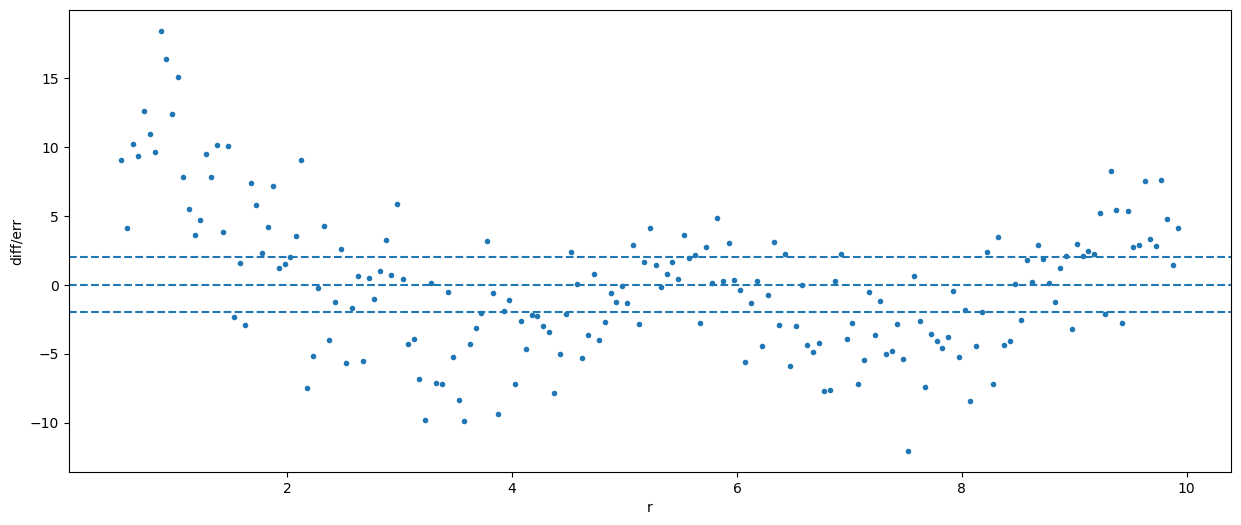

In [6]:
fig, ax_bot = plt.subplots(figsize = (15, 6))

ax_bot.plot(bin_avg, diff_xi, marker='.', ls='')
ax_bot.axhline(0, ls='--')
ax_bot.axhline(2, ls='--')
ax_bot.axhline(-2, ls='--')
ax_bot.set_xlabel("r")
ax_bot.set_ylabel("diff/err")

[ 0.58106324  1.25081651  5.41070116  3.92027474 -0.64553205  0.57206731
  0.81315412  1.04916823  0.33593483  0.74942178]


array([ 0.58106324,  1.25081651,  5.41070116,  3.92027474, -0.64553205,
        0.57206731,  0.81315412,  1.04916823,  0.33593483,  0.74942178])

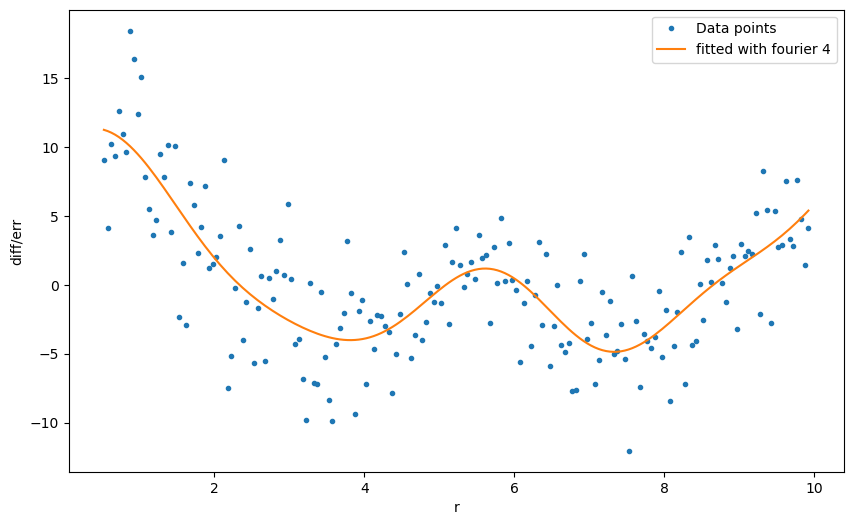

In [28]:
initial_guess = [0.5, 2, 4, 2, 2, 3, 5, 2, 2, 3]
fourier_fit_diff_xi(bin_avg, diff_xi, initial_guess)

In [6]:
def fourier_series4(params, x):
    """Dynamically generated fitting function for Fourier series."""
    w, a0, a1, a2, a3, a4, b1, b2, b3, b4 = params

    result = a0 + a1 * np.cos(w * x) + a2 * np.cos(2 * w * x) + a3 * np.cos(3 * w * x) \
                + a4 * np.cos(4 * w * x) + b1 * np.sin(w * x) + b2 * np.sin(2 * w * x) \
                + b3 * np.sin(3 * w * x) + b4 * np.sin(4 * w * x)
    
    return result

fourier_series4_v = np.vectorize(fourier_series4, excluded=['params'])

def lnlike(params, x, y, y_err):
    y_mod = fourier_series4(params, x)

    Lnlike = np.sum( np.power((y - y_mod)/y_err, 2) * (-0.5))
    return Lnlike

def lnprior(params):
    low_lim = np.ones_like(params) * -10
    up_lim = np.ones_like(params) * 10

    if np.all(params >= low_lim) & np.all(params <= up_lim):
        return 0.0
    else:
        return -np.inf
    
def lnprob(params, x, y, y_err):
    lp = lnprior(params)
    if np.isinf(lp):
        return -np.inf
    else:
        return lp + lnlike(params, x, y, y_err)

(5000000, 10)


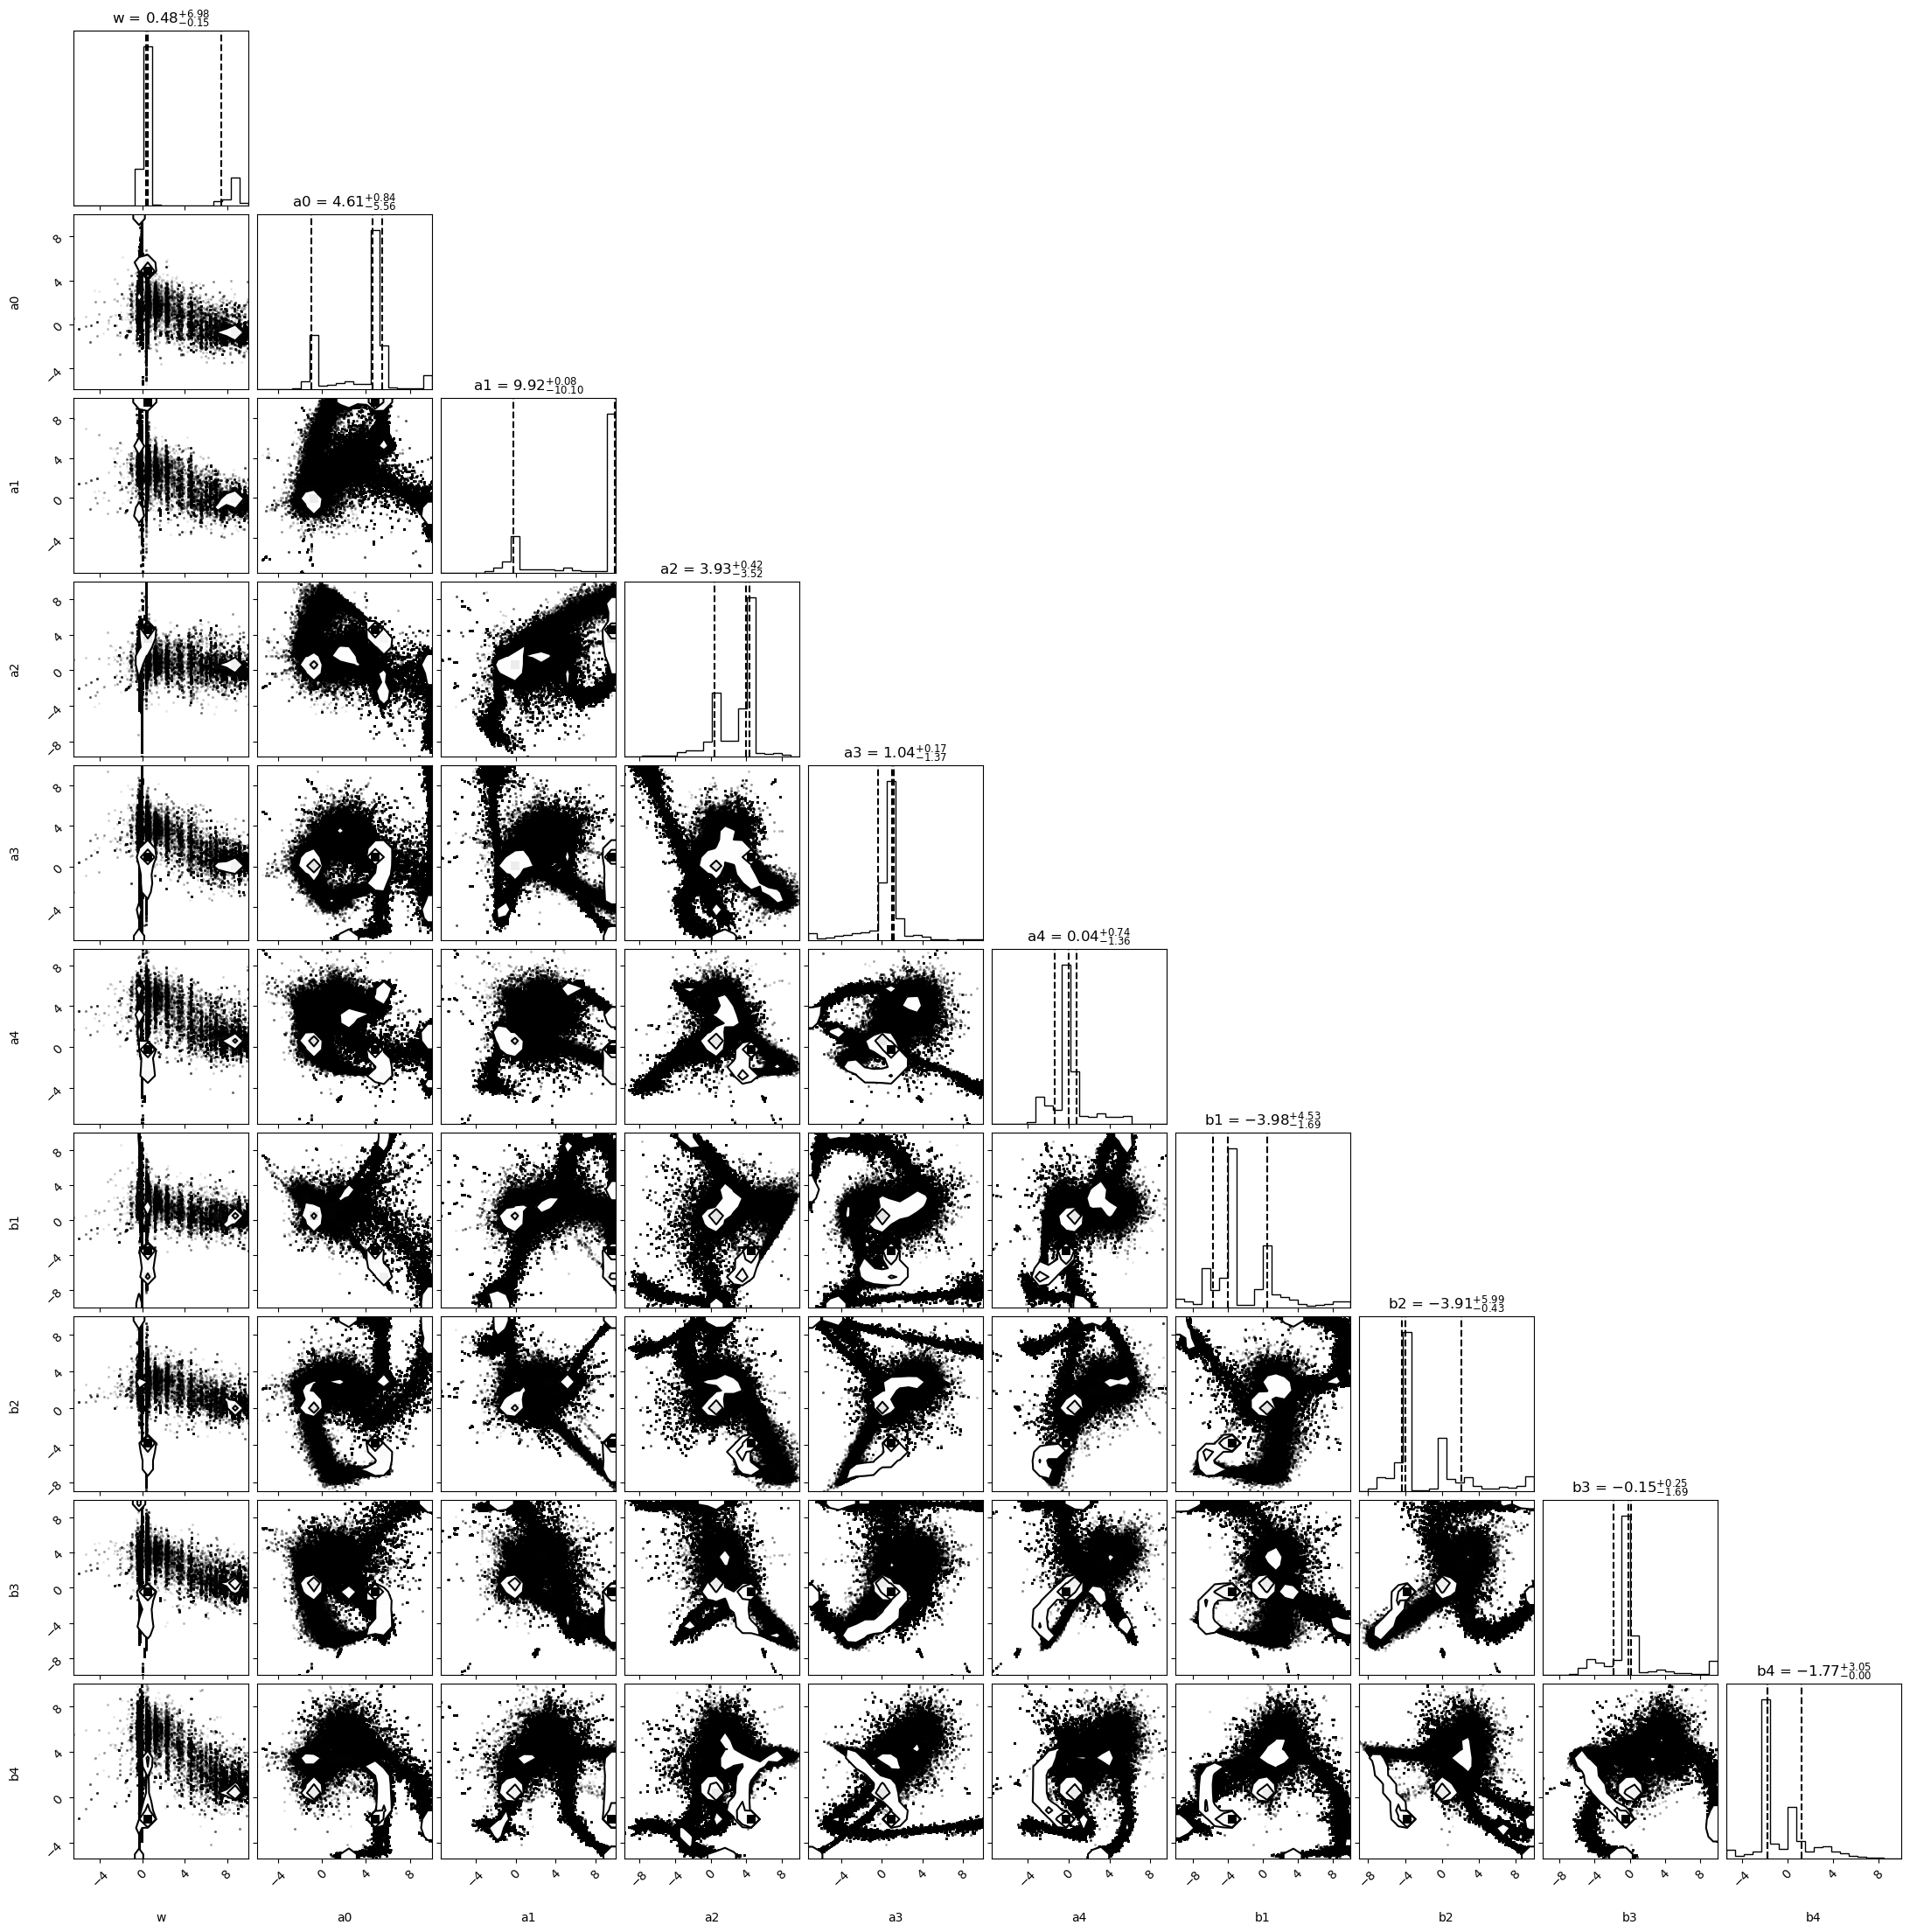

In [16]:
diff_err = (error + error2)/2

initial = np.array([1, 2, 3, 1, 4, 5, 2, 3, 4, 6])
ndim = len(initial)

nwalkers = 1000
data = (bin_avg, diff_xi, diff_err)

p0 = [np.array(initial) + np.random.randn(ndim) for i in range(nwalkers)]

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=data)
sampler.run_mcmc(p0, 1000);
sampler.reset()

sampler.run_mcmc(p0, 5000);

samples = sampler.flatchain
print(samples.shape)

import corner
mpl.rcParams['font.size'] = 14
labels = ['w', 'a0', 'a1', 'a2', 'a3', 'a4', 'b1', 'b2', 'b3', 'b4']
fig = corner.corner(samples, show_titles=True, labels=labels, plot_datapoints=True, quantiles=[0.16, 0.5, 0.84])
plt.show()

Text(0, 0.5, 'diff/err')

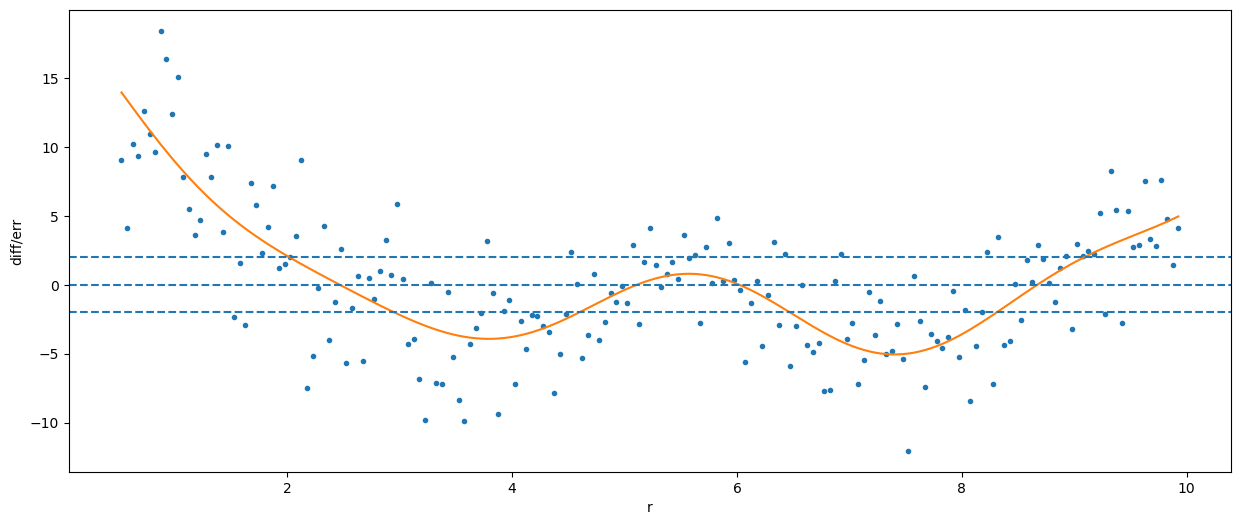

In [27]:
best_fit_params = [0.48, 4.61, 9.92, 3.93, 1.04, 0.04, -3.98, -3.91, -0.15, -1.77]

diff_xi_fit = fourier_series4(best_fit_params, bin_avg)

fig, ax_bot = plt.subplots(figsize = (15, 6))

ax_bot.plot(bin_avg, diff_xi, marker='.', ls='')

ax_bot.plot(bin_avg, diff_xi_fit)

ax_bot.axhline(0, ls='--')
ax_bot.axhline(2, ls='--')
ax_bot.axhline(-2, ls='--')
ax_bot.set_xlabel("r")
ax_bot.set_ylabel("diff/err")

In [3]:
grade = np.arange(0, 10.1, 0.1)
compl_map = np.ones_like(grade[:-1])
grade_avg = np.array((grade[:-1] + grade[1:])/2)
ind = np.where((grade > 6) & (grade < 8))[0]
compl_map[ind[np.where((ind[1:] - ind[:-1]) == 1)]] = 0.5

xi2, error2 = completness_map_effects_without_ran_adjust(x_dat2, y_dat2, z_dat2, compl_map);
plt.close()

diff_xi = compare_compl_effect_with_original(xi2, error2, xi, error, title=r"$\xi$ of incomplete data vs complete data without incompleteness applied to random")
plt.close()

Total time take = 2.26 s
Total time take = 2.36 s
Total time take = 2.42 s
Total time take = 2.46 s
Total time take = 2.47 s
Total time take = 2.51 s
Total time take = 2.69 s
Total time take = 2.57 s
Total time take = 2.65 s
Total time take = 2.62 s
The number of data points retained = 870


[ 0.67892194 -0.73757336  0.54262027  0.82782155  0.82266297 -0.13642065
 -1.60354503  0.4516224   0.04640766  1.03931954]


array([ 0.67892194, -0.73757336,  0.54262027,  0.82782155,  0.82266297,
       -0.13642065, -1.60354503,  0.4516224 ,  0.04640766,  1.03931954])

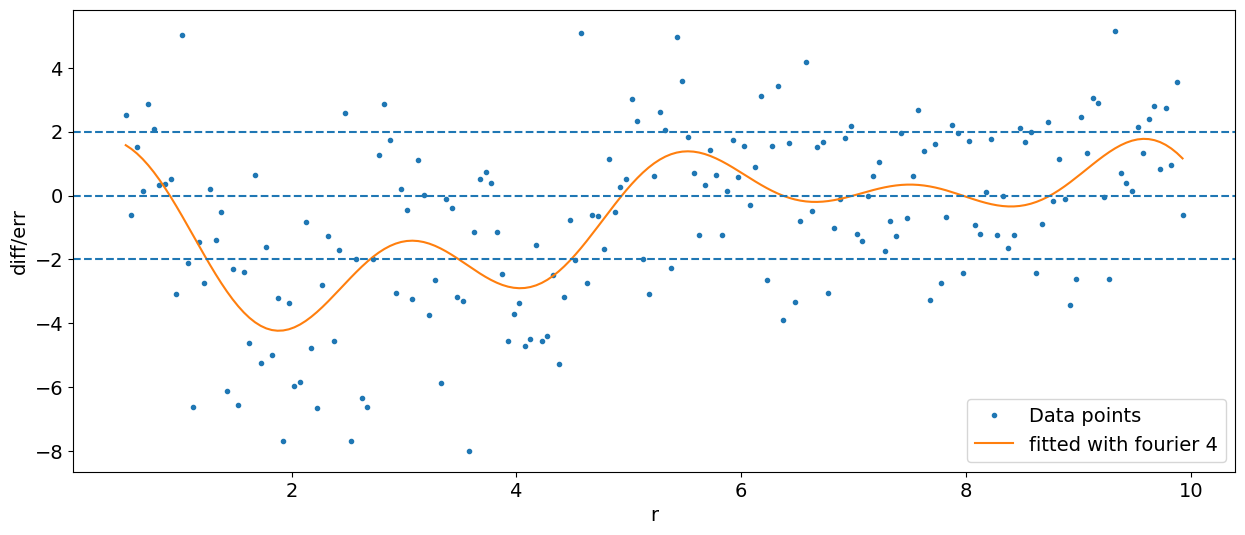

In [14]:
initial_guess = [0.5, 2, 4, 2, 2, 3, 5, 2, 2, 3]
fourier_fit_diff_xi(bin_avg, diff_xi, initial_guess)

(5000000, 10)


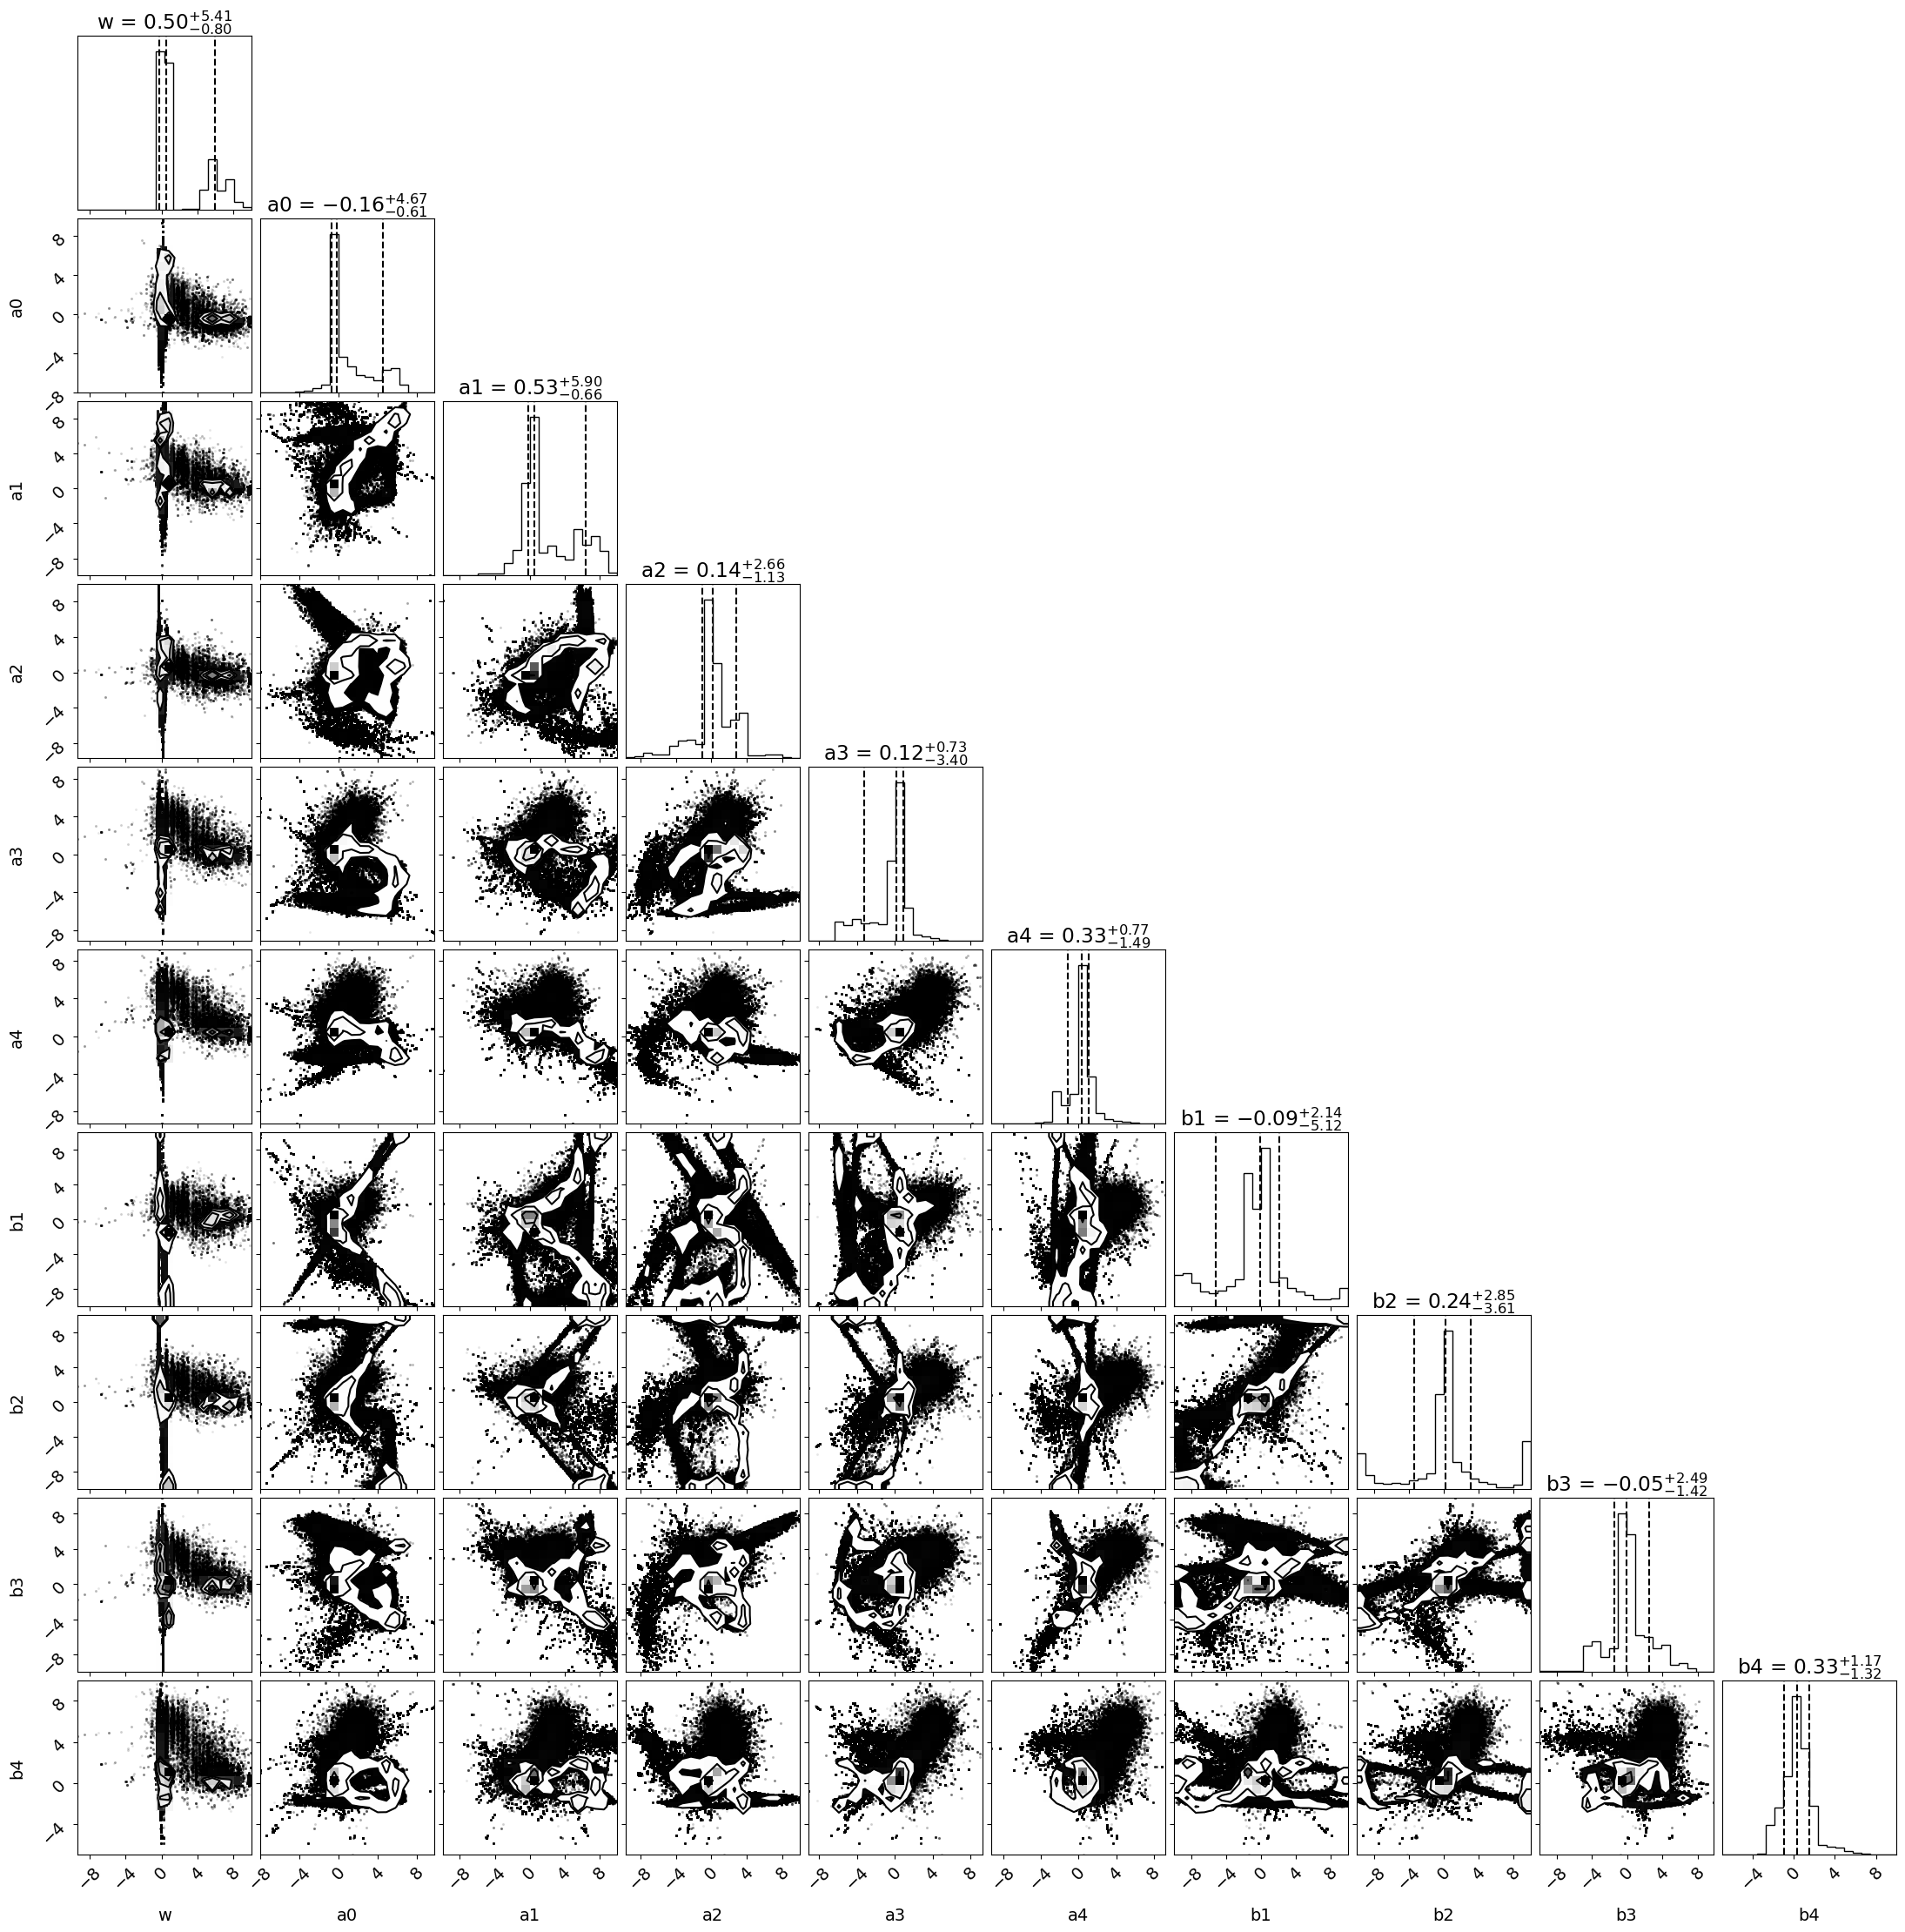

In [10]:
diff_err = (error + error2)/2

initial = np.array([1, 2, 3, 1, 4, 5, 2, 3, 4, 6])
ndim = len(initial)

nwalkers = 1000
data = (bin_avg, diff_xi, diff_err)

p0 = [np.array(initial) + np.random.randn(ndim) for i in range(nwalkers)]

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=data)
sampler.run_mcmc(p0, 1000);
sampler.reset()

sampler.run_mcmc(p0, 5000);

samples = sampler.flatchain
print(samples.shape)

import corner
mpl.rcParams['font.size'] = 14
labels = ['w', 'a0', 'a1', 'a2', 'a3', 'a4', 'b1', 'b2', 'b3', 'b4']
fig = corner.corner(samples, show_titles=True, labels=labels, plot_datapoints=True, quantiles=[0.16, 0.5, 0.84])
plt.show()

Text(0, 0.5, 'diff/err')

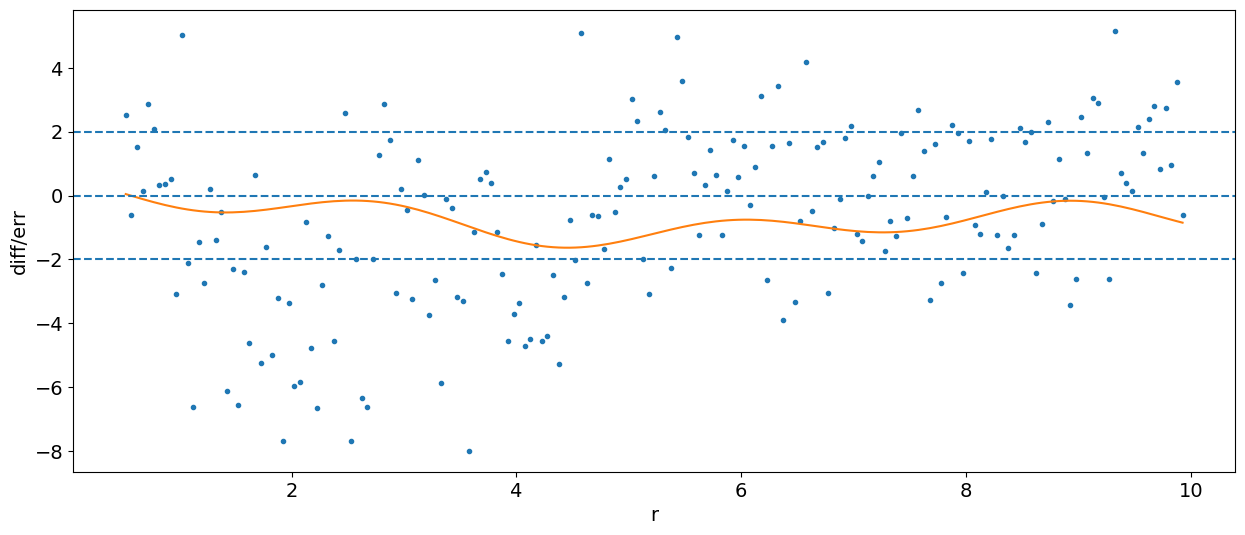

In [11]:
best_fit_params = [0.50, -0.61, 0.53, 0.14, 0.12, 0.33, -0.09, 0.24, -0.05, -0.33]

diff_xi_fit = fourier_series4(best_fit_params, bin_avg)

fig, ax_bot = plt.subplots(figsize = (15, 6))

ax_bot.plot(bin_avg, diff_xi, marker='.', ls='')

ax_bot.plot(bin_avg, diff_xi_fit)

ax_bot.axhline(0, ls='--')
ax_bot.axhline(2, ls='--')
ax_bot.axhline(-2, ls='--')
ax_bot.set_xlabel("r")
ax_bot.set_ylabel("diff/err")

## Incompleteness is applied to random field to check variation.

## Making log-normal mock and doing the analysis

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [18]:
import numpy as np

In [2]:
from nbodykit.lab import *
from nbodykit import style, setup_logging

import matplotlib.pyplot as plt
plt.style.use(style.notebook)

/home/vibin/anaconda3/envs/nbodykit-env/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
setup_logging()

In [27]:
redshift = 0.55
cosmo = cosmology.Planck15
Plin = cosmology.LinearPower(cosmo, redshift, transfer='EisensteinHu')
b1 = 2.0

cat = LogNormalCatalog(Plin=Plin, nbar=3e-3, BoxSize=128., Nmesh=256, bias=b1, seed=42)

[ 000931.07 ]   0: 09-19 18:04  LogNormalCatalog INFO     Growth Rate is 0.770123
[ 000931.07 ]   0: 09-19 18:04  LogNormalCatalog INFO     Generating whitenoise


[ 000933.88 ]   0: 09-19 18:04  LogNormalCatalog INFO     Write noise generated
[ 000935.23 ]   0: 09-19 18:04  LogNormalCatalog INFO     Displacement computed in fourier space
[ 000935.78 ]   0: 09-19 18:04  LogNormalCatalog INFO     Overdensity computed in configuration space: std = 3.082451427909274
[ 000937.47 ]   0: 09-19 18:04  LogNormalCatalog INFO     Displacement computed in configuration space: std = [3.559603668182194, 3.1939288363617564, 3.644429457899878]
[ 000937.49 ]   0: 09-19 18:04  LogNormalCatalog INFO     gaussian field is generated
[ 000937.69 ]   0: 09-19 18:04  LogNormalCatalog INFO     Lognormal transformation done
[ 000938.95 ]   0: 09-19 18:04  LogNormalCatalog INFO     Poisson sampling done, total number of objects is 6305
[ 000943.14 ]   0: 09-19 18:04  LogNormalCatalog INFO     catalog produced. Assigning in cell shift.
[ 000943.14 ]   0: 09-19 18:04  LogNormalCatalog INFO     sorting done
[ 000943.15 ]   0: 09-19 18:04  LogNormalCatalog INFO     catalog sh

In [28]:
catalog_pos = cat['Position']

x_pos = np.asarray(catalog_pos[:,0])
y_pos = np.asarray(catalog_pos[:,1])
z_pos = np.asarray(catalog_pos[:,2])


In [31]:
catalog_pos = np.asarray(cat['Position'])

In [34]:
catalog_pos = catalog_pos.T

In [35]:
np.save('lognormal_mock_v1.npy', catalog_pos)

Text(0.5, 0.92, 'Distribution of clustered points following power law')

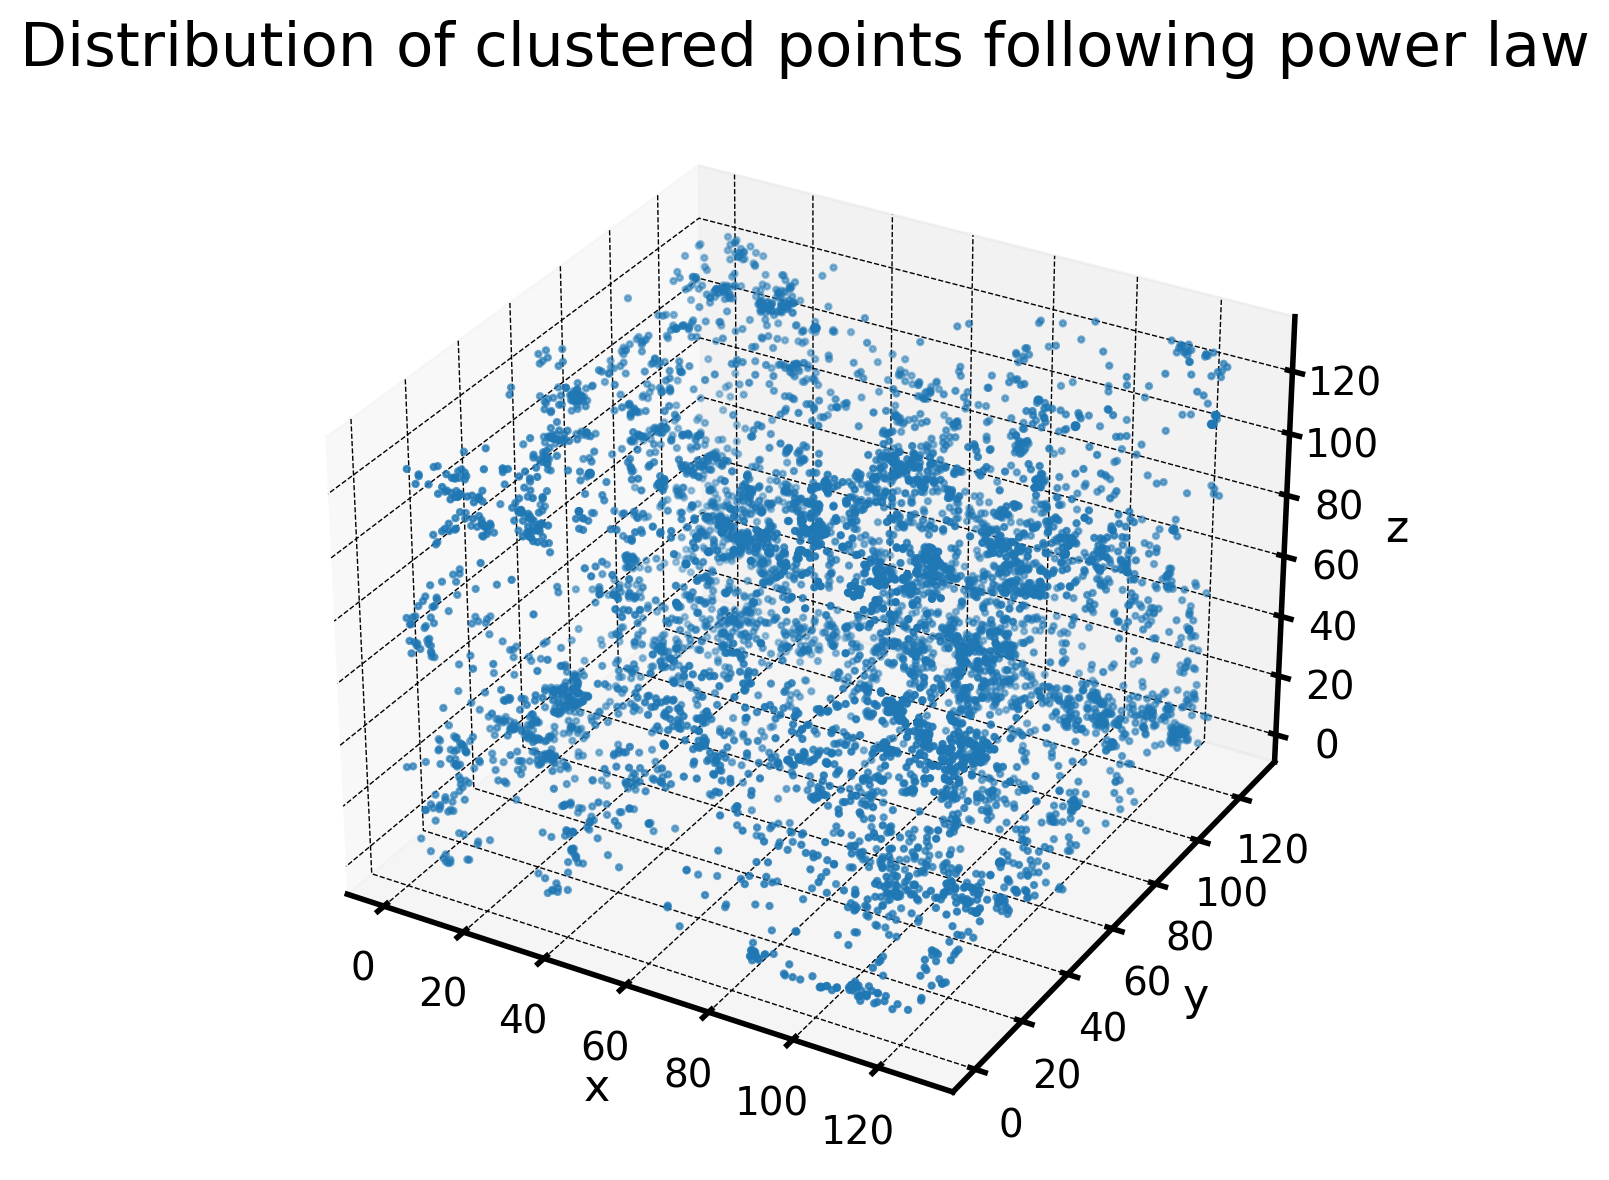

In [29]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(x_pos, y_pos, z_pos, s=4)
#ax.plot(x_dat2, y_dat2, z_dat2, c='r', lw=0.5)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title("Distribution of clustered points following power law")

## Doing the analysis

In [3]:
data = np.load('lognormal_mock_v1.npy')

x_dat, y_dat, z_dat = data

Text(0.5, 0.92, 'Distribution of the log-normal mock')

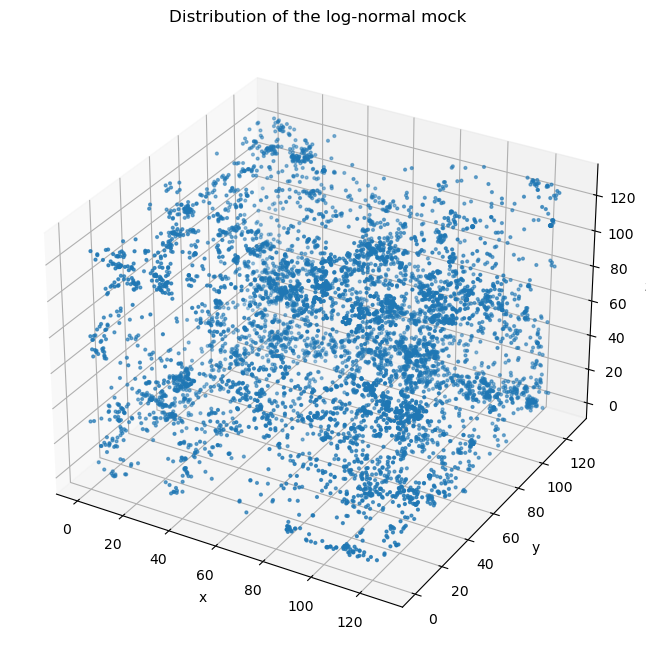

In [22]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection='3d')
ax.scatter(x_dat, y_dat, z_dat, s=4)
#ax.plot(x_dat2, y_dat2, z_dat2, c='r', lw=0.5)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title("Distribution of the log-normal mock")

In [4]:
bin_start = 1
bin_end = 40
bin_width = 1
box_size = 128

bins = np.arange(bin_start, bin_end, bin_width)
bin_avg = np.array((bins[:-1] + bins[1:])/2)

In [5]:
grade = np.arange(0, 128, 0.1)
compl_map = np.ones_like(grade[:-1])

xi_avg_arr = np.zeros((100, len(bin_avg)))
error_avg_arr = np.zeros((100, len(bin_avg)))

for i in range(100):
    start = time.time()

    xi2, error2 = completness_map_effects_without_ran_adjust_v2(x_dat, y_dat, z_dat, compl_map, grade, bins, box_size)
    plt.close()

    xi_avg_arr[i] = np.average(xi2, axis=0)
    error_avg_arr[i] = np.sqrt(np.average(error2**2, axis=0)/len(error2))
    
    end = time.time()
    print("Total time take = {} s".format(round(end-start,2)))

[Warning] The CPU supports AVX2 but the compiler does not.  Can you try another compiler?
[Warning] The CPU supports AVX but the compiler does not.  Can you try another compiler?
[Warning] The CPU supports SSE4.2 but the compiler does not.  Can you try another compiler?
[Warning] The CPU supports SSE4.1 but the compiler does not.  Can you try another compiler?
[Warning] The CPU supports SSSE3 but the compiler does not.  Can you try another compiler?


The number of data points retained = 6299
Total time take = 3.34 s
The number of data points retained = 6299
Total time take = 2.45 s
The number of data points retained = 6299
Total time take = 2.58 s
The number of data points retained = 6299
Total time take = 2.68 s
The number of data points retained = 6299
Total time take = 2.81 s
The number of data points retained = 6299
Total time take = 2.71 s
The number of data points retained = 6299
Total time take = 2.53 s
The number of data points retained = 6299
Total time take = 2.49 s
The number of data points retained = 6299
Total time take = 2.45 s
The number of data points retained = 6299
Total time take = 2.42 s
The number of data points retained = 6299
Total time take = 2.56 s
The number of data points retained = 6299
Total time take = 2.44 s
The number of data points retained = 6299
Total time take = 2.45 s
The number of data points retained = 6299
Total time take = 2.44 s
The number of data points retained = 6299
Total time take = 2.

In [6]:
def find_cov_xi(xi_avg_arr):
    tot_avg_xi_arr = np.average(xi_avg_arr, axis=0)
    N = len(xi_avg_arr)
    l = len(tot_avg_xi_arr)

    cov_xi = np.zeros((l,l))

    for i in range(l):
        for j in range(l):
            for k in range(N):
                cov_xi[i][j] += (xi_avg_arr[k][i] - tot_avg_xi_arr[i]) * (xi_avg_arr[k][j] - tot_avg_xi_arr[j])
            cov_xi[i][j] *= 1/(N-1)

    return tot_avg_xi_arr, cov_xi

In [7]:
tot_avg_xi_arr, cov_xi = find_cov_xi(xi_avg_arr)

std_dev = np.sqrt(np.diag(cov_xi))
std_x, std_y = np.meshgrid(std_dev, std_dev)
corr_xi = cov_xi/(std_x * std_y)

Text(0.5, 1.0, 'correlation matrix of complete mock')

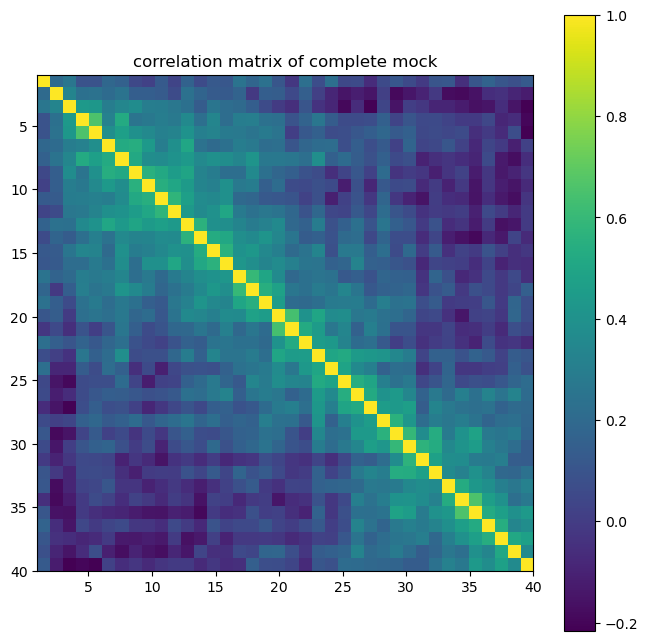

In [32]:
fig, ax_corr = plt.subplots(figsize=(8,8))

im = ax_corr.imshow(corr_xi, extent=[1,40,40,1])
fig.colorbar(im)
ax_corr.set_title("correlation matrix of complete mock")

Text(0.5, 0, 'r')

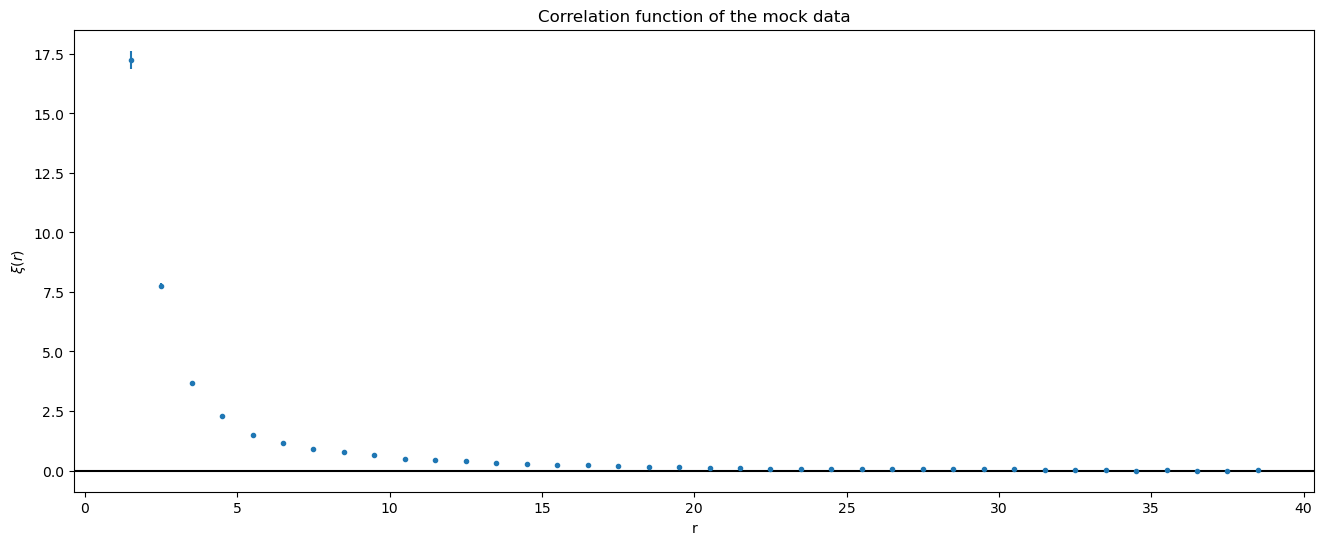

In [9]:
fig, ax = plt.subplots(figsize = (16,6))

ax.errorbar(bin_avg, tot_avg_xi_arr, yerr=std_dev, ls=' ', marker='.')
ax.axhline(color='black')
ax.set_title("Correlation function of the mock data")
ax.set_ylabel(r"$\xi(r)$")
ax.set_xlabel(r"r")

The number of data points retained = 5957
The number of data points retained = 5957
The number of data points retained = 5957
The number of data points retained = 5957
The number of data points retained = 5957
The number of data points retained = 5957
The number of data points retained = 5957
The number of data points retained = 5957
The number of data points retained = 5957
The number of data points retained = 5957
The number of data points retained = 5957
The number of data points retained = 5957
The number of data points retained = 5957
The number of data points retained = 5957
The number of data points retained = 5957
The number of data points retained = 5957
The number of data points retained = 5957
The number of data points retained = 5957
The number of data points retained = 5957
The number of data points retained = 5957
The number of data points retained = 5957
The number of data points retained = 5957
The number of data points retained = 5957
The number of data points retained

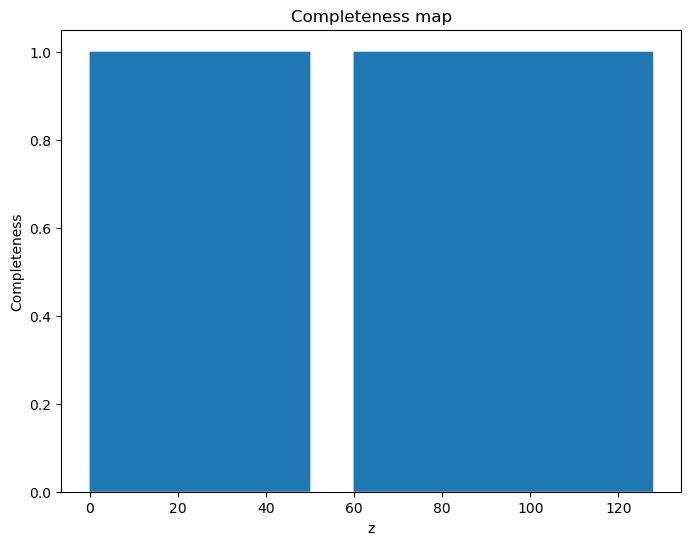

In [10]:
grade = np.arange(0, 128, 0.1)
compl_map = np.ones_like(grade[:-1])
grade_avg = np.array((grade[:-1] + grade[1:])/2)
ind = np.where((grade > 50) & (grade < 60))[0]
compl_map[ind[np.where((ind[1:] - ind[:-1]) == 1)]] = 0.0

fig, ax_com = plt.subplots(figsize=(8,6))

ax_com.stairs(compl_map, grade, fill=True)
ax_com.set_title("Completeness map")
ax_com.set_ylabel("Completeness")
ax_com.set_xlabel("z")


xi_avg_arr_comp = np.zeros((100, len(bin_avg)))
error_avg_arr_comp = np.zeros((100, len(bin_avg)))

for i in range(100):

    xi2, error2 = completness_map_effects_with_ran_adjust_v2(x_dat, y_dat, z_dat, compl_map, grade, bins, box_size)
    plt.close()

    xi_avg_arr_comp[i] = np.average(xi2, axis=0)
    error_avg_arr_comp[i] = np.sqrt(np.average(error2**2, axis=0)/len(error2))

tot_avg_xi_arr_comp, cov_xi_comp = find_cov_xi(xi_avg_arr_comp)

std_dev_comp = np.sqrt(np.diag(cov_xi_comp))
std_x, std_y = np.meshgrid(std_dev_comp, std_dev_comp)
corr_xi_comp = cov_xi_comp/(std_x * std_y)

Text(0.5, 1.0, 'correlation matrix')

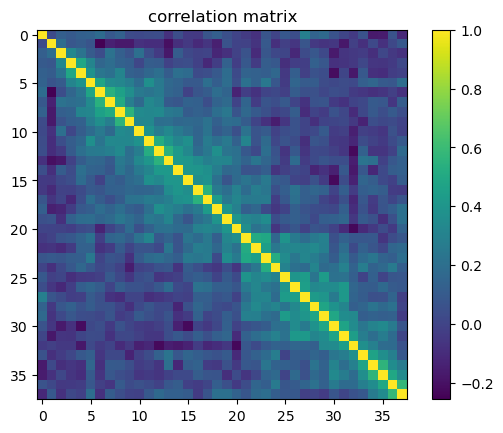

In [37]:
plt.imshow(corr_xi_comp)
plt.colorbar()
plt.title("correlation matrix")

Text(0, 0.5, 'residual')

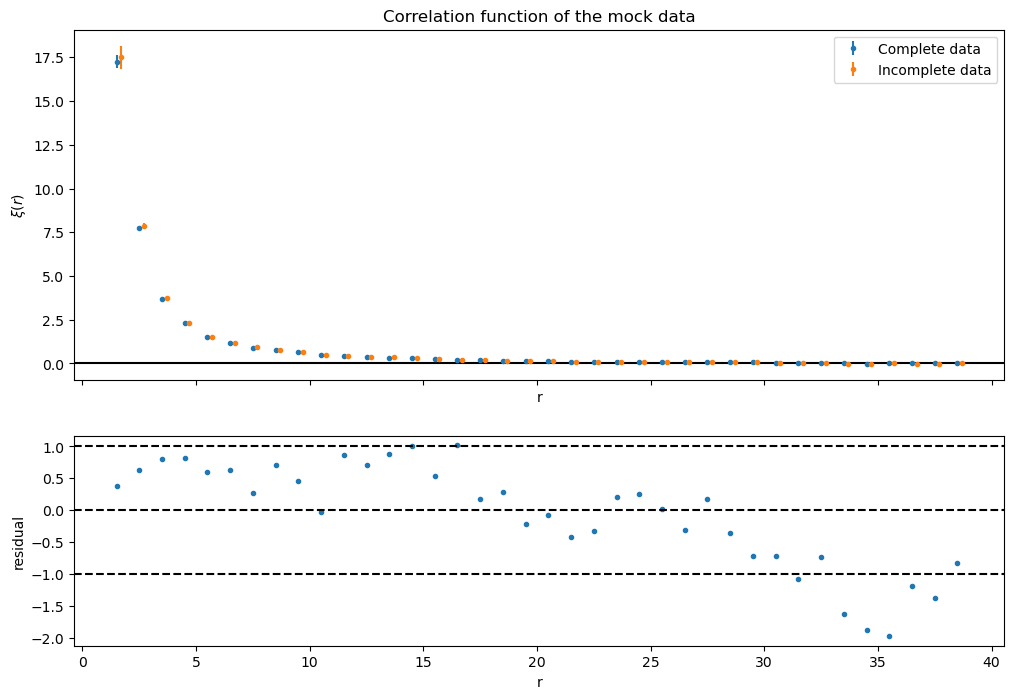

In [11]:
fig, (ax, ax_bot) = plt.subplots(2,1, figsize = (12,8), sharex = True, height_ratios=(5,3))

ax.errorbar(bin_avg, tot_avg_xi_arr, yerr=std_dev, ls=' ', marker='.', label="Complete data")
ax.errorbar(bin_avg+0.2, tot_avg_xi_arr_comp, yerr=std_dev_comp, ls=' ', marker='.', label="Incomplete data")
ax.axhline(color='black')
ax.set_title("Correlation function of the mock data")
ax.set_ylabel(r"$\xi(r)$")
ax.set_xlabel(r"r")
ax.legend()

diff_xi = (tot_avg_xi_arr_comp - tot_avg_xi_arr)/(std_dev_comp)

ax_bot.plot(bin_avg, diff_xi, ls = ' ', marker='.')
ax_bot.axhline(0, ls='--', color='black')
ax_bot.axhline(1, ls='--', color='black')
ax_bot.axhline(-1, ls='--', color='black')
ax_bot.set_xlabel("r")
ax_bot.set_ylabel("residual")

In [19]:
def calc_chi_sqr(tot_xi_avg_arr, xi_avg_arr_comp, cov_xi_comp):
    inv_cov_xi_comp = np.linalg.inv(cov_xi_comp)
    dim = len(tot_xi_avg_arr)
    chi_sqr = np.zeros(len(xi_avg_arr_comp))

    for k in range(len(xi_avg_arr_comp)):
        for i in range(dim):
            for j in range(dim):
                chi_sqr[k] += (xi_avg_arr_comp[k][i] - tot_xi_avg_arr[i]) * inv_cov_xi_comp[i][j] * (xi_avg_arr_comp[k][j] - tot_xi_avg_arr[j])
    
    return chi_sqr

Text(0.5, 0, '$\\chi^2$')

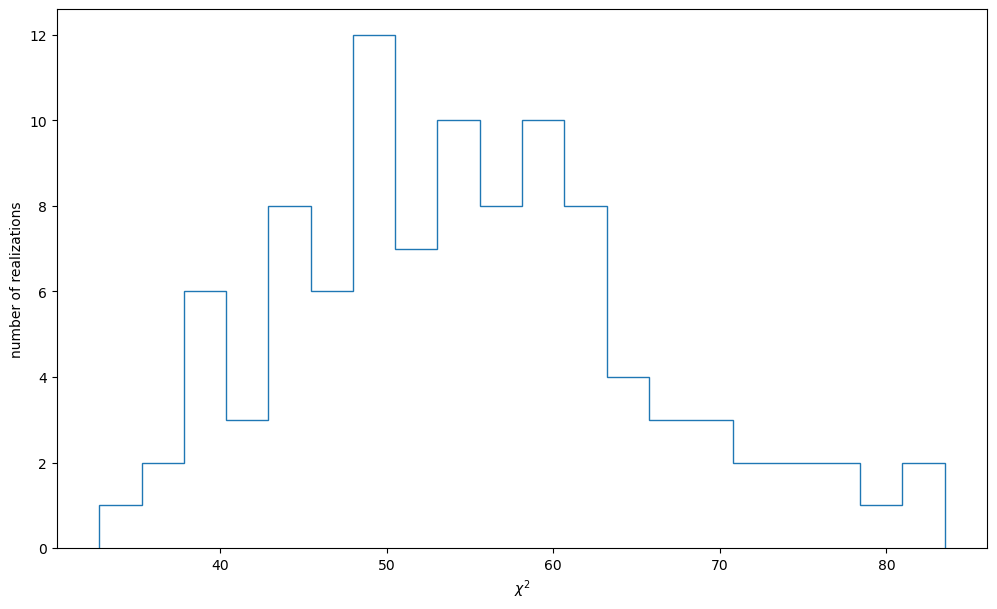

In [28]:
chi_sqr = calc_chi_sqr(tot_avg_xi_arr, xi_avg_arr_comp, cov_xi_comp)

fig, ax_xi = plt.subplots(figsize=(12,7))
ax_xi.hist(chi_sqr, bins=20, histtype='step')
ax_xi.set_ylabel("number of realizations")
ax_xi.set_xlabel(r"$\chi^2$")

The number of data points retained = 4427
The number of data points retained = 4427
The number of data points retained = 4427
The number of data points retained = 4427
The number of data points retained = 4427
The number of data points retained = 4427
The number of data points retained = 4427
The number of data points retained = 4427
The number of data points retained = 4427
The number of data points retained = 4427
The number of data points retained = 4427
The number of data points retained = 4427
The number of data points retained = 4427
The number of data points retained = 4427
The number of data points retained = 4427
The number of data points retained = 4427
The number of data points retained = 4427
The number of data points retained = 4427
The number of data points retained = 4427
The number of data points retained = 4427
The number of data points retained = 4427
The number of data points retained = 4427
The number of data points retained = 4427
The number of data points retained

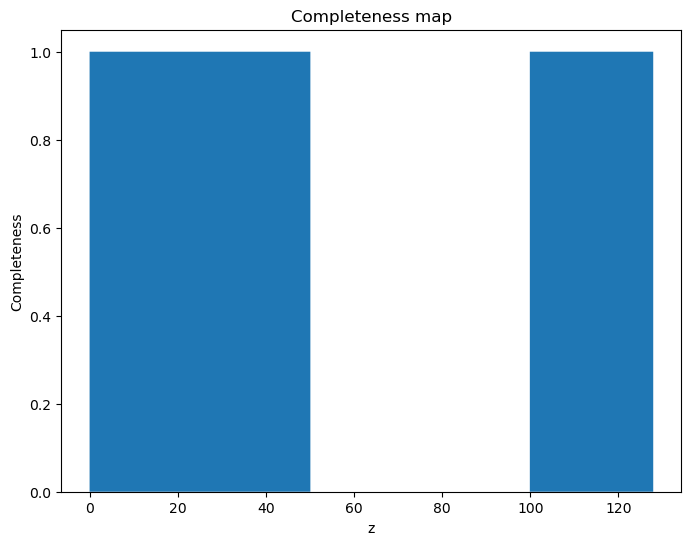

In [50]:
grade = np.arange(0, 128, 0.1)
compl_map = np.ones_like(grade[:-1])
grade_avg = np.array((grade[:-1] + grade[1:])/2)
ind = np.where((grade > 50) & (grade < 100))[0]
compl_map[ind[np.where((ind[1:] - ind[:-1]) == 1)]] = 0.0

fig, ax_com = plt.subplots(figsize=(8,6))

ax_com.stairs(compl_map, grade, fill=True)
ax_com.set_title("Completeness map")
ax_com.set_ylabel("Completeness")
ax_com.set_xlabel("z")


xi_avg_arr_comp2 = np.zeros((100, len(bin_avg)))
error_avg_arr_comp2 = np.zeros((100, len(bin_avg)))

for i in range(100):

    xi2, error2 = completness_map_effects_with_ran_adjust_v2(x_dat, y_dat, z_dat, compl_map, grade, bins, box_size)
    plt.close()

    xi_avg_arr_comp2[i] = np.average(xi2, axis=0)
    error_avg_arr_comp2[i] = np.sqrt(np.average(error2**2, axis=0)/len(error2))

In [51]:
tot_avg_xi_arr_comp2, cov_xi_comp2 = find_cov_xi(xi_avg_arr_comp2)

std_dev_comp2 = np.sqrt(np.diag(cov_xi_comp2))
std_x, std_y = np.meshgrid(std_dev_comp2, std_dev_comp2)
corr_xi_comp2 = cov_xi_comp2/(std_x * std_y)

Text(0.5, 1.0, 'correlation matrix')

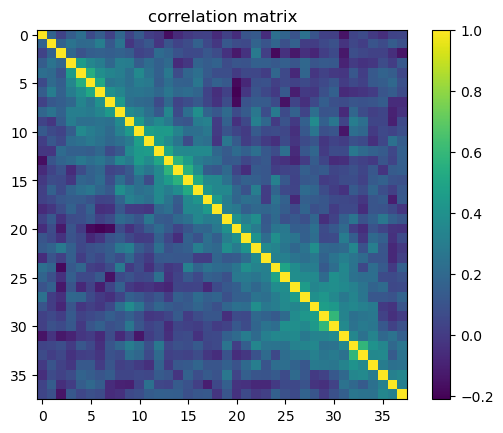

In [52]:
plt.imshow(corr_xi_comp2)
plt.colorbar()
plt.title("correlation matrix")

Text(0, 0.5, 'diff/err')

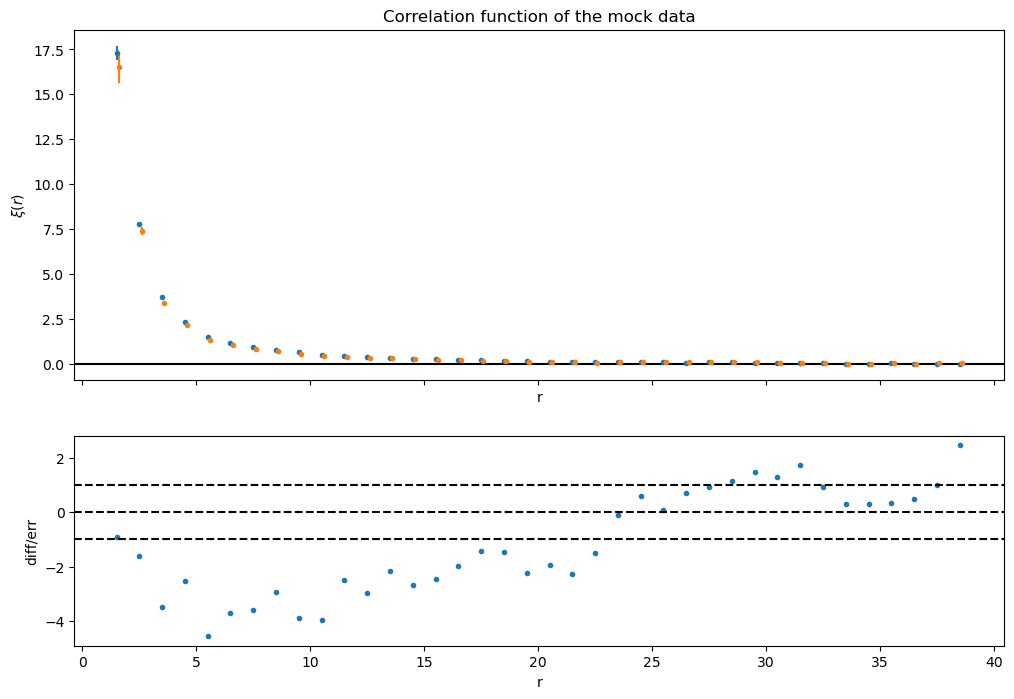

In [54]:
fig, (ax, ax_bot) = plt.subplots(2,1, figsize = (12,8), sharex = True, height_ratios=(5,3))

ax.errorbar(bin_avg, tot_avg_xi_arr, yerr=std_dev, ls=' ', marker='.')
ax.errorbar(bin_avg+0.1, tot_avg_xi_arr_comp2, yerr=std_dev_comp2, ls=' ', marker='.')
ax.axhline(color='black')
ax.set_title("Correlation function of the mock data")
ax.set_ylabel(r"$\xi(r)$")
ax.set_xlabel(r"r")

diff_xi = (tot_avg_xi_arr_comp2 - tot_avg_xi_arr)/(std_dev_comp2)

ax_bot.plot(bin_avg, diff_xi, ls = ' ', marker='.')
ax_bot.axhline(0, ls='--', color='black')
ax_bot.axhline(1, ls='--', color='black')
ax_bot.axhline(-1, ls='--', color='black')
ax_bot.set_xlabel("r")
ax_bot.set_ylabel("diff/err")

The number of data points retained = 2430
The number of data points retained = 2430
The number of data points retained = 2430
The number of data points retained = 2430
The number of data points retained = 2430
The number of data points retained = 2430
The number of data points retained = 2430
The number of data points retained = 2430
The number of data points retained = 2430
The number of data points retained = 2430
The number of data points retained = 2430
The number of data points retained = 2430
The number of data points retained = 2430
The number of data points retained = 2430
The number of data points retained = 2430
The number of data points retained = 2430
The number of data points retained = 2430
The number of data points retained = 2430
The number of data points retained = 2430
The number of data points retained = 2430
The number of data points retained = 2430
The number of data points retained = 2430
The number of data points retained = 2430
The number of data points retained

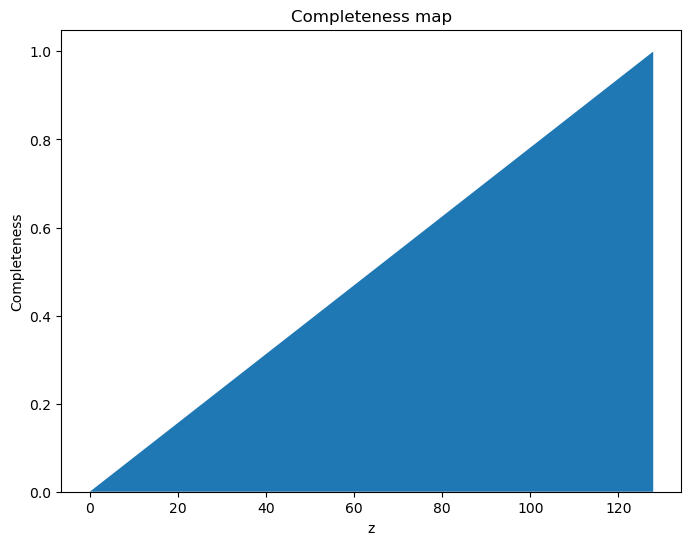

In [55]:
grade = np.arange(0, 128, 0.1)
compl_map = np.ones_like(grade[:-1])
grade_avg = np.array((grade[:-1] + grade[1:])/2)
# ind = np.where((grade > 50) & (grade < 100))[0]
# compl_map[ind[np.where((ind[1:] - ind[:-1]) == 1)]] = 0.0
len_comp = len(compl_map)
for i in range(len(compl_map)):
    compl_map[i] = i * 1/len_comp

fig, ax_com = plt.subplots(figsize=(8,6))

ax_com.stairs(compl_map, grade, fill=True)
ax_com.set_title("Completeness map")
ax_com.set_ylabel("Completeness")
ax_com.set_xlabel("z")


xi_avg_arr_comp3 = np.zeros((100, len(bin_avg)))
error_avg_arr_comp3 = np.zeros((100, len(bin_avg)))

for i in range(100):

    xi2, error2 = completness_map_effects_with_ran_adjust_v2(x_dat, y_dat, z_dat, compl_map, grade, bins, box_size)
    plt.close()

    xi_avg_arr_comp3[i] = np.average(xi2, axis=0)
    error_avg_arr_comp3[i] = np.sqrt(np.average(error2**2, axis=0)/len(error2))

Text(0.5, 1.0, 'correlation matrix')

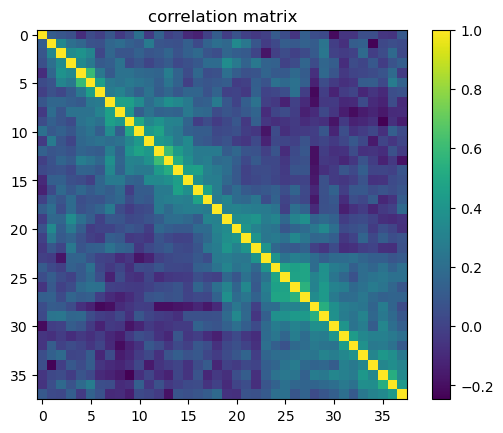

In [56]:
tot_avg_xi_arr_comp3, cov_xi_comp3 = find_cov_xi(xi_avg_arr_comp3)

std_dev_comp3 = np.sqrt(np.diag(cov_xi_comp3))
std_x, std_y = np.meshgrid(std_dev_comp3, std_dev_comp3)
corr_xi_comp3 = cov_xi_comp3/(std_x * std_y)

plt.imshow(corr_xi_comp3)
plt.colorbar()
plt.title("correlation matrix")

NameError: name 'tot_avg_xi_arr_comp3' is not defined

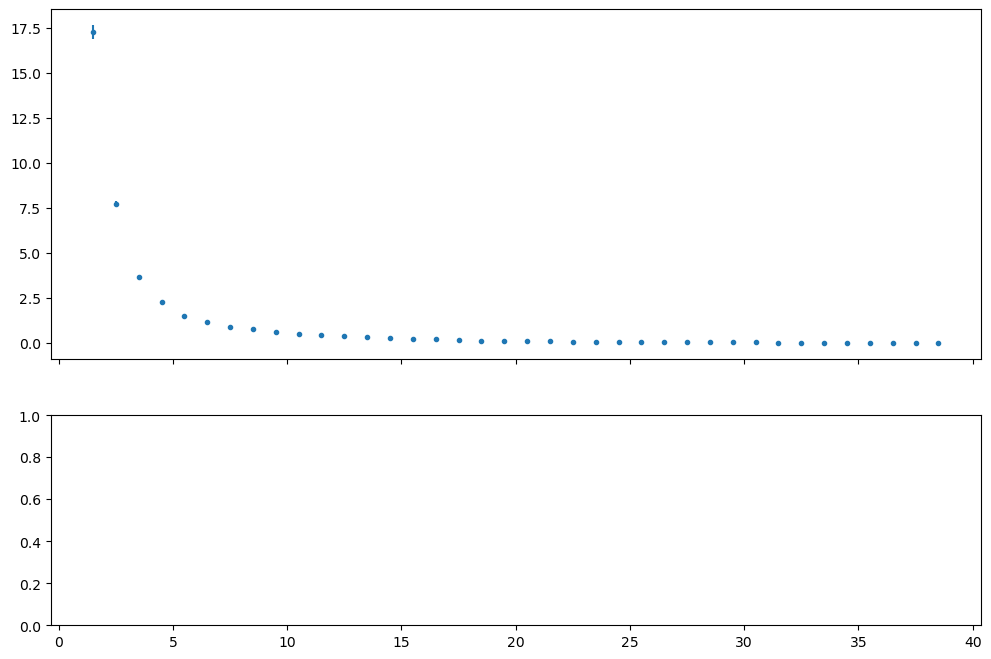

In [29]:
fig, (ax, ax_bot) = plt.subplots(2,1, figsize = (12,8), sharex = True, height_ratios=(5,3))

ax.errorbar(bin_avg, tot_avg_xi_arr, yerr=std_dev, ls=' ', marker='.')
ax.errorbar(bin_avg+0.2, tot_avg_xi_arr_comp3, yerr=std_dev_comp3, ls=' ', marker='.')
ax.axhline(color='black')
ax.set_title("Correlation function of the mock data")
ax.set_ylabel(r"$\xi(r)$")
ax.set_xlabel(r"r")

diff_xi = (tot_avg_xi_arr_comp3 - tot_avg_xi_arr)/(std_dev_comp3)

ax_bot.plot(bin_avg, diff_xi, ls = ' ', marker='.')
ax_bot.axhline(0, ls='--', color='black')
ax_bot.axhline(1, ls='--', color='black')
ax_bot.axhline(-1, ls='--', color='black')
ax_bot.set_xlabel("r")
ax_bot.set_ylabel("diff/err")

## Clutter control

In [2]:
def find_cov_xi(xi_avg_arr):
    tot_avg_xi_arr = np.average(xi_avg_arr, axis=0)
    N = len(xi_avg_arr)
    l = len(tot_avg_xi_arr)

    cov_xi = np.zeros((l,l))

    for i in range(l):
        for j in range(l):
            for k in range(N):
                cov_xi[i][j] += (xi_avg_arr[k][i] - tot_avg_xi_arr[i]) * (xi_avg_arr[k][j] - tot_avg_xi_arr[j])
            cov_xi[i][j] *= 1/(N-1)

    return tot_avg_xi_arr, cov_xi

In [3]:
data = np.load('lognormal_mock_v1.npy')

x_dat, y_dat, z_dat = data

bin_start = 1
bin_end = 40
bin_width = 1
box_size = 128

bins = np.arange(bin_start, bin_end, bin_width)
bin_avg = np.array((bins[:-1] + bins[1:])/2)

In [4]:
grade = np.arange(0, 128, 1.0)
compl_map = np.ones_like(grade[:-1])

xi_avg_arr = np.zeros((100, len(bin_avg)))
error_avg_arr = np.zeros((100, len(bin_avg)))

for i in range(100):
    start = time.time()

    xi2, error2 = completness_map_effects_without_ran_adjust_v2(x_dat, y_dat, z_dat, compl_map, grade, bins, box_size)
    plt.close()

    xi_avg_arr[i] = np.average(xi2, axis=0)
    error_avg_arr[i] = np.sqrt(np.average(error2**2, axis=0)/len(error2))
    
    end = time.time()
    print("Total time take = {} s".format(round(end-start,2)))

[Warning] The CPU supports AVX2 but the compiler does not.  Can you try another compiler?
[Warning] The CPU supports AVX but the compiler does not.  Can you try another compiler?
[Warning] The CPU supports SSE4.2 but the compiler does not.  Can you try another compiler?
[Warning] The CPU supports SSE4.1 but the compiler does not.  Can you try another compiler?
[Warning] The CPU supports SSSE3 but the compiler does not.  Can you try another compiler?


The number of data points retained = 6237
Total time take = 2.03 s
The number of data points retained = 6237
Total time take = 2.04 s
The number of data points retained = 6237
Total time take = 2.16 s
The number of data points retained = 6237
Total time take = 1.98 s
The number of data points retained = 6237
Total time take = 2.21 s
The number of data points retained = 6237
Total time take = 2.0 s
The number of data points retained = 6237
Total time take = 2.02 s
The number of data points retained = 6237
Total time take = 2.35 s
The number of data points retained = 6237
Total time take = 2.09 s
The number of data points retained = 6237
Total time take = 2.05 s
The number of data points retained = 6237
Total time take = 2.04 s
The number of data points retained = 6237
Total time take = 2.21 s
The number of data points retained = 6237
Total time take = 2.13 s
The number of data points retained = 6237
Total time take = 2.14 s
The number of data points retained = 6237
Total time take = 2.2

Text(0.5, 0, 'r')

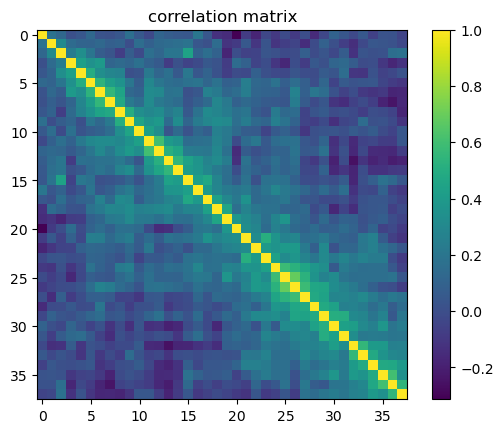

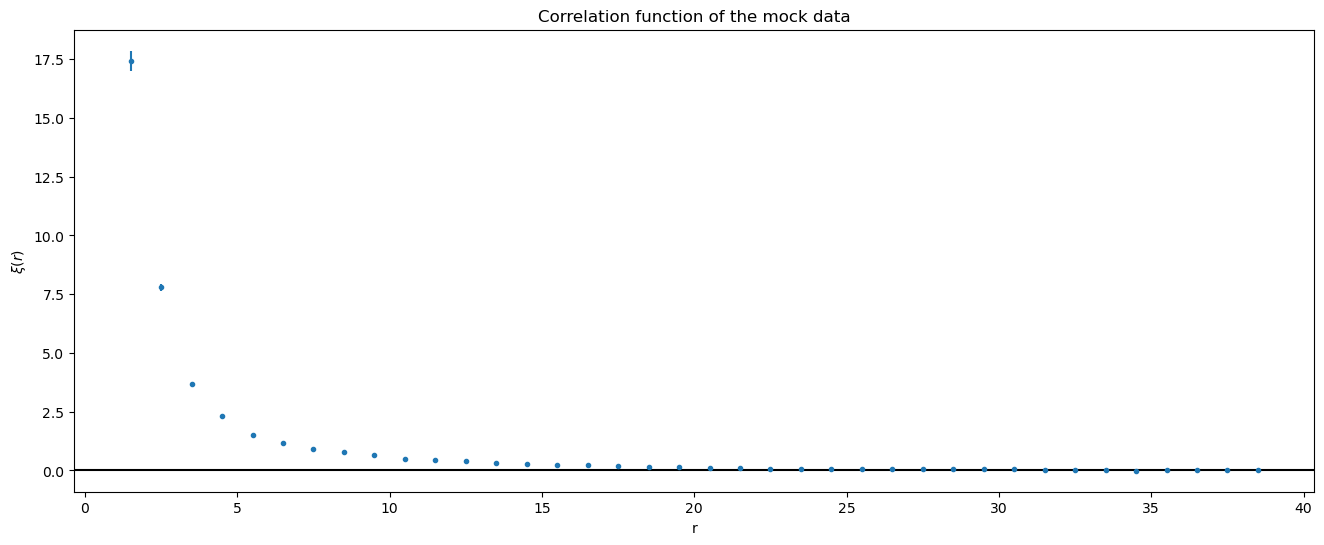

In [5]:
tot_avg_xi_arr, cov_xi = find_cov_xi(xi_avg_arr)

std_dev = np.sqrt(np.diag(cov_xi))
std_x, std_y = np.meshgrid(std_dev, std_dev)
corr_xi = cov_xi/(std_x * std_y)

plt.imshow(corr_xi)
plt.colorbar()
plt.title("correlation matrix")

fig, ax = plt.subplots(figsize = (16,6))

ax.errorbar(bin_avg, tot_avg_xi_arr, yerr=std_dev, ls=' ', marker='.')
ax.axhline(color='black')
ax.set_title("Correlation function of the mock data")
ax.set_ylabel(r"$\xi(r)$")
ax.set_xlabel(r"r")

Text(0.5, 0, 'z')

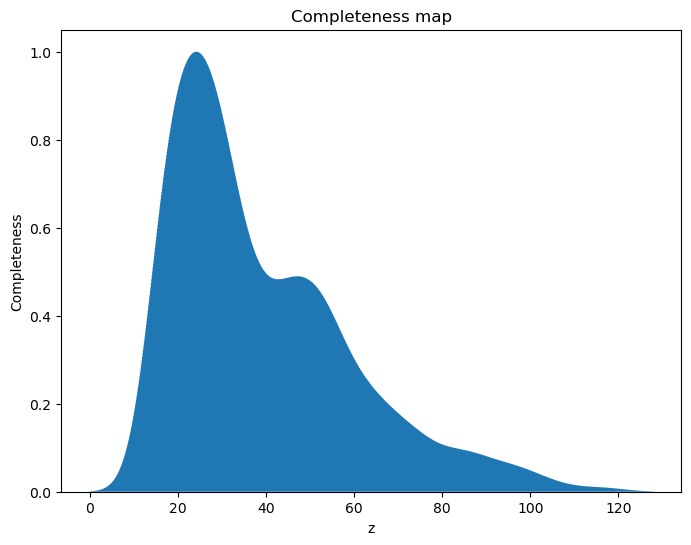

In [17]:
smoothed_nz = (np.load('shen_nz_smoothed.npy'))[0][:-1]

grade = np.arange(0, 128, 0.1)
compl_map = np.ones_like(grade[:-1])
grade_avg = np.array((grade[:-1] + grade[1:])/2)
ind = np.where((grade > 50) & (grade < 60))[0]
compl_map = smoothed_nz/np.max(smoothed_nz)

fig, ax_com = plt.subplots(figsize=(8,6))

ax_com.stairs(compl_map, grade, fill=True)
ax_com.set_title("Completeness map")
ax_com.set_ylabel("Completeness")
ax_com.set_xlabel("z")

The number of data points retained = 1899
The number of data points retained = 1899
The number of data points retained = 1899
The number of data points retained = 1899
The number of data points retained = 1899
The number of data points retained = 1899
The number of data points retained = 1899
The number of data points retained = 1899
The number of data points retained = 1899
The number of data points retained = 1899
The number of data points retained = 1899
The number of data points retained = 1899
The number of data points retained = 1899
The number of data points retained = 1899
The number of data points retained = 1899
The number of data points retained = 1899
The number of data points retained = 1899
The number of data points retained = 1899
The number of data points retained = 1899
The number of data points retained = 1899
The number of data points retained = 1899
The number of data points retained = 1899
The number of data points retained = 1899
The number of data points retained

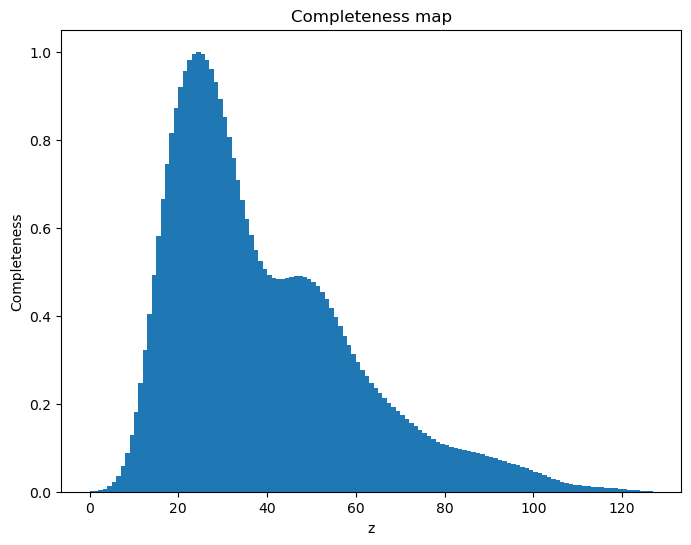

In [6]:
smoothed_nz = (np.load('shen_nz_smoothed_v2.npy'))[0][:-1]

grade = np.arange(0, 128, 1)
compl_map = np.ones_like(grade[:-1])
grade_avg = np.array((grade[:-1] + grade[1:])/2)
ind = np.where((grade > 50) & (grade < 60))[0]
compl_map = smoothed_nz/np.max(smoothed_nz)

fig, ax_com = plt.subplots(figsize=(8,6))

ax_com.stairs(compl_map, grade, fill=True)
ax_com.set_title("Completeness map")
ax_com.set_ylabel("Completeness")
ax_com.set_xlabel("z")


xi_avg_arr_shen_nz = np.zeros((100, len(bin_avg)))
error_avg_arr_shen_nz = np.zeros((100, len(bin_avg)))

for i in range(100):

    xi2, error2 = completness_map_effects_with_ran_adjust_v2(x_dat, y_dat, z_dat, compl_map, grade, bins, box_size)
    plt.close()

    xi_avg_arr_shen_nz[i] = np.average(xi2, axis=0)
    error_avg_arr_shen_nz[i] = np.sqrt(np.average(error2**2, axis=0)/len(error2))

tot_avg_xi_arr_shen_nz, cov_xi_shen_nz = find_cov_xi(xi_avg_arr_shen_nz)

std_dev_shen_nz = np.sqrt(np.diag(cov_xi_shen_nz))
std_x, std_y = np.meshgrid(std_dev_shen_nz, std_dev_shen_nz)
corr_xi_shen_nz = cov_xi_shen_nz/(std_x * std_y)

Text(0, 0.5, 'residual')

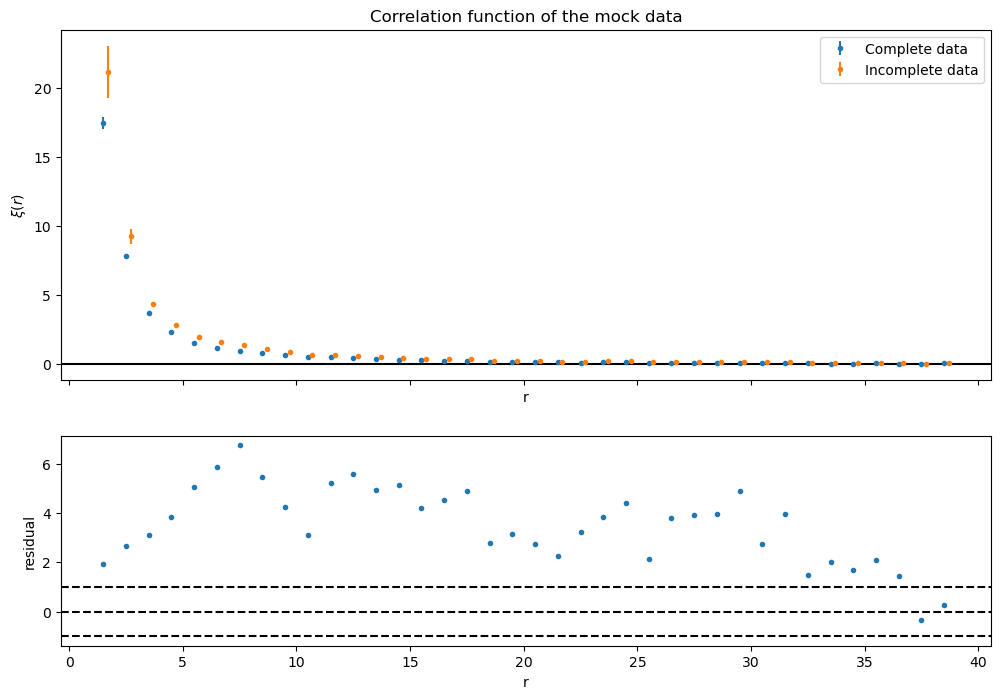

In [7]:
fig, (ax, ax_bot) = plt.subplots(2,1, figsize = (12,8), sharex = True, height_ratios=(5,3))

ax.errorbar(bin_avg, tot_avg_xi_arr, yerr=std_dev, ls=' ', marker='.', label="Complete data")
ax.errorbar(bin_avg+0.2, tot_avg_xi_arr_shen_nz, yerr=std_dev_shen_nz, ls=' ', marker='.', label="Incomplete data")
ax.axhline(color='black')
ax.set_title("Correlation function of the mock data")
ax.set_ylabel(r"$\xi(r)$")
ax.set_xlabel(r"r")
ax.legend()

diff_xi = (tot_avg_xi_arr_shen_nz - tot_avg_xi_arr)/(std_dev_shen_nz)

ax_bot.plot(bin_avg, diff_xi, ls = ' ', marker='.')
ax_bot.axhline(0, ls='--', color='black')
ax_bot.axhline(1, ls='--', color='black')
ax_bot.axhline(-1, ls='--', color='black')
ax_bot.set_xlabel("r")
ax_bot.set_ylabel("residual")

Text(0.5, 1.0, 'correlation matrix of complete mock')

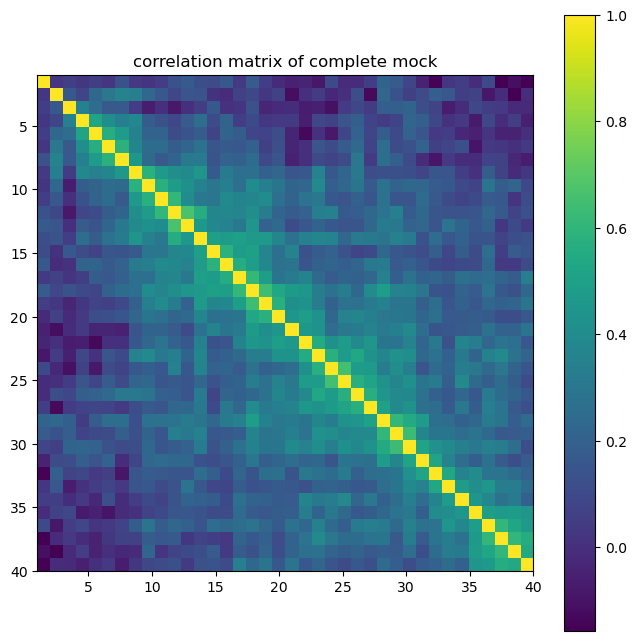

In [66]:
fig, ax_corr = plt.subplots(figsize=(8,8))

im = ax_corr.imshow(corr_xi_shen_nz, extent=[1,40,40,1])
fig.colorbar(im)
ax_corr.set_title("correlation matrix of complete mock")

(-1.0, 5.0)

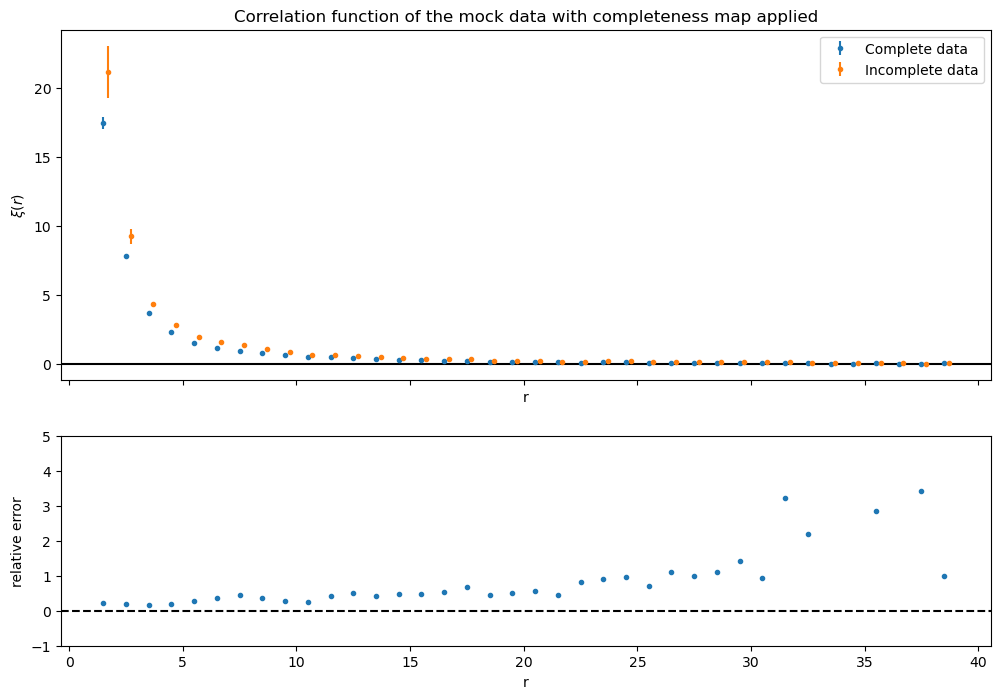

In [8]:
fig, (ax, ax_bot) = plt.subplots(2,1, figsize = (12,8), sharex = True, height_ratios=(5,3))

ax.errorbar(bin_avg, tot_avg_xi_arr, yerr=std_dev, ls=' ', marker='.', label="Complete data")
ax.errorbar(bin_avg+0.2, tot_avg_xi_arr_shen_nz, yerr=std_dev_shen_nz, ls=' ', marker='.', label="Incomplete data")
ax.axhline(color='black')
ax.set_title("Correlation function of the mock data with completeness map applied")
ax.set_ylabel(r"$\xi(r)$")
ax.set_xlabel(r"r")
ax.legend()

rel_diff_xi = (tot_avg_xi_arr_shen_nz - tot_avg_xi_arr)/(tot_avg_xi_arr)

ax_bot.plot(bin_avg, rel_diff_xi, ls = ' ', marker='.')
ax_bot.axhline(0, ls='--', color='black')
# ax_bot.axhline(1, ls='--', color='black')
# ax_bot.axhline(-1, ls='--', color='black')
ax_bot.set_xlabel("r")
ax_bot.set_ylabel("relative error")
ax_bot.set_ylim(-1,5)

The number of data points retained = 1925
The number of data points retained = 1925
The number of data points retained = 1925
The number of data points retained = 1925
The number of data points retained = 1925
The number of data points retained = 1925
The number of data points retained = 1925
The number of data points retained = 1925
The number of data points retained = 1925
The number of data points retained = 1925
The number of data points retained = 1925
The number of data points retained = 1925
The number of data points retained = 1925
The number of data points retained = 1925
The number of data points retained = 1925
The number of data points retained = 1925
The number of data points retained = 1925
The number of data points retained = 1925
The number of data points retained = 1925
The number of data points retained = 1925
The number of data points retained = 1925
The number of data points retained = 1925
The number of data points retained = 1925
The number of data points retained

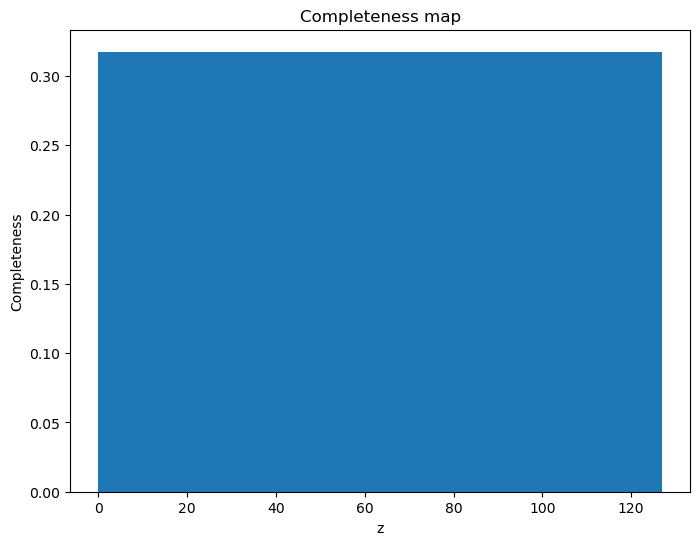

In [10]:
grade = np.arange(0, 128, 1.0)
compl_map = np.ones_like(grade[:-1]) * (2000/6299)
# grade_avg = np.array((grade[:-1] + grade[1:])/2)
# ind = np.where((grade >= 0) & (grade < 60))[0]

fig, ax_com = plt.subplots(figsize=(8,6))

ax_com.stairs(compl_map, grade, fill=True)
ax_com.set_title("Completeness map")
ax_com.set_ylabel("Completeness")
ax_com.set_xlabel("z")


xi_avg_arr_uni = np.zeros((100, len(bin_avg)))
error_avg_arr_uni = np.zeros((100, len(bin_avg)))

for i in range(100):

    xi2, error2 = completness_map_effects_with_ran_adjust_v2(x_dat, y_dat, z_dat, compl_map, grade, bins, box_size)
    plt.close()

    xi_avg_arr_uni[i] = np.average(xi2, axis=0)
    error_avg_arr_uni[i] = np.sqrt(np.average(error2**2, axis=0)/len(error2))

tot_avg_xi_arr_uni, cov_xi_uni = find_cov_xi(xi_avg_arr_uni)

std_dev_uni = np.sqrt(np.diag(cov_xi_uni))
std_x, std_y = np.meshgrid(std_dev_uni, std_dev_uni)
corr_xi_uni = cov_xi_uni/(std_x * std_y)

(-1.0, 5.0)

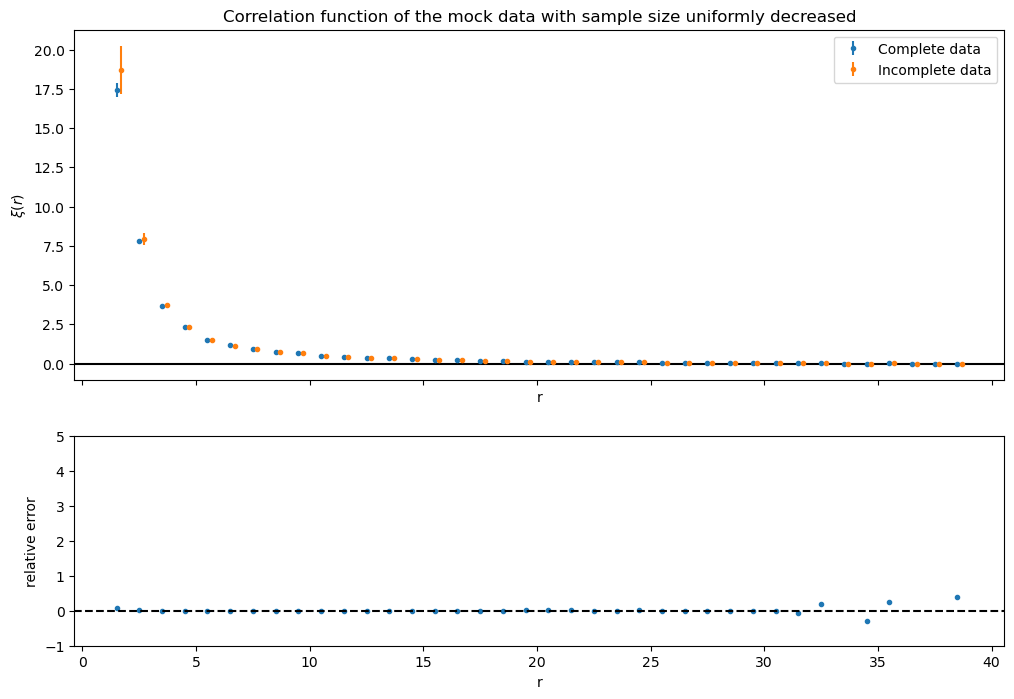

In [11]:
fig, (ax, ax_bot) = plt.subplots(2,1, figsize = (12,8), sharex = True, height_ratios=(5,3))

ax.errorbar(bin_avg, tot_avg_xi_arr, yerr=std_dev, ls=' ', marker='.', label="Complete data")
ax.errorbar(bin_avg+0.2, tot_avg_xi_arr_uni, yerr=std_dev_uni, ls=' ', marker='.', label="Incomplete data")
ax.axhline(color='black')
ax.set_title("Correlation function of the mock data with sample size uniformly decreased")
ax.set_ylabel(r"$\xi(r)$")
ax.set_xlabel(r"r")
ax.legend()

rel_diff_xi = (tot_avg_xi_arr_uni - tot_avg_xi_arr)/(tot_avg_xi_arr)

ax_bot.plot(bin_avg, rel_diff_xi, ls = ' ', marker='.')
ax_bot.axhline(0, ls='--', color='black')
# ax_bot.axhline(1, ls='--', color='black')
# ax_bot.axhline(-1, ls='--', color='black')
ax_bot.set_xlabel("r")
ax_bot.set_ylabel("relative error")
ax_bot.set_ylim(-1,5)

## Correlation function and the error bar

In [27]:
grade = np.arange(0, 128, 0.1)
compl_map = np.ones_like(grade[:-1])

xi_avg_arr = np.zeros((100, len(bin_avg)))
error_avg_arr = np.zeros((100, len(bin_avg)))

for i in range(100):
    start = time.time()

    xi2, error2 = completness_map_effects_without_ran_adjust_v2(x_dat, y_dat, z_dat, compl_map, grade, bins, box_size)
    plt.close()

    xi_avg_arr[i] = np.average(xi2, axis=0)
    error_avg_arr[i] = np.sqrt(np.average(error2**2, axis=0)/len(error2))
    
    end = time.time()
    print("Total time take = {} s".format(round(end-start,2)))

tot_avg_xi_arr, cov_xi = find_cov_xi(xi_avg_arr)

std_dev = np.sqrt(np.diag(cov_xi))
std_x, std_y = np.meshgrid(std_dev, std_dev)
corr_xi = cov_xi/(std_x * std_y)

The number of data points retained = 6299
Total time take = 2.19 s
The number of data points retained = 6299
Total time take = 2.21 s
The number of data points retained = 6299
Total time take = 2.34 s
The number of data points retained = 6299
Total time take = 2.3 s
The number of data points retained = 6299
Total time take = 2.3 s
The number of data points retained = 6299
Total time take = 2.36 s
The number of data points retained = 6299
Total time take = 2.36 s
The number of data points retained = 6299
Total time take = 2.28 s
The number of data points retained = 6299
Total time take = 2.43 s
The number of data points retained = 6299
Total time take = 2.37 s
The number of data points retained = 6299
Total time take = 2.45 s
The number of data points retained = 6299
Total time take = 2.41 s
The number of data points retained = 6299
Total time take = 2.5 s
The number of data points retained = 6299
Total time take = 2.42 s
The number of data points retained = 6299
Total time take = 2.4 s

In [1]:
fig, ax = plt.subplots(figsize = (16,6))

ax.errorbar(bin_avg, tot_avg_xi_arr, yerr=std_dev, ls=' ', marker='.')
ax.axhline(color='black')
ax.set_title("Correlation function of the mock data")
ax.set_ylabel(r"$\xi(r)$")
ax.set_xlabel(r"r")

for i in range(len(xi_avg_arr)):
    ax.plot(bin_avg, xi_avg_arr[i], ls = ' ', marker='.')

NameError: name 'plt' is not defined